# Data loading

In [2]:
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import random 

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats
from tqdm import tqdm

import os
import plotly.io as pio

import xgboost as xgb
from sklearn.model_selection import train_test_split
import wandb
from wandb.xgboost import WandbCallback

from sklearn.metrics import accuracy_score

wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ntg2208. Use `wandb login --relogin` to force relogin


True

### Merge json files

In [3]:
file1 = 'data/data-2-2-23.json'
file2 = 'data/data-14-3-23.json'
output = 'data/merged_data.json'
# london_tz = 'Europe/London'

with open(file1, 'rb') as f:
    data = json.load(f)
with open(file2, 'rb') as f:
    data.update(json.load(f))   
with open(output, 'w') as f:
    json.dump(data, f)   

userIds = list(data.keys())
id = 'QOQ0hkp1w8'
print(data.keys(), len(data.keys()))

dict_keys(['54hFUuEnJA', 'KpZ0DlA0Qa', 'gymn4uQetH', 'JqZPr3q1LD', 'CCGlM7KPWU', 'T00mMEwEZQ', 'vyXgu5Y2Ir', 'M6AnBk7QDC', 'D9ueoHithb', 'yA5oo0mfBh', 'qIbpO14xtQ', 'tQH2goO6X7', 'qehDXrIutg', 'IH37N8bmqr', 'x5FkDfHIeb', 'QOQ0hkp1w8', 'bNC0L6XLKF', 'eos78kZgv7', '1r2J9taZha', 'RCyHQ6rpvv', '7YEwUZuc8D', 'FhOlzVfEIL', 'AfV9dmJtMm', 'HEUjBr7iWG', 'PN1zc7wTMT', 'ILi5G9vycp', 'hWKgqVxmMM', 'vvRWUiYuo0', 'YQ5JZShUmU', 'TD9pplcD4k', '0tbGZHzjR7', 'NB01kHhAKl', '6Ujss5DCym', 'FhEb2UWpsc', 'lkEP97xGWa', 'vmFt8cc4jE', 'WcSXVvGRh1', 'yHK1hn0pTA', 'Bigvbc0mbI', 'tMpBFEEHKj', '2dbVKUDzd5', '3kRR5MPMyj', 'BzirdGuQ3W', 'PAsFOF8cXY', 'xwF8hGon4W', 'AkZCK3y8qH', 'mkxN5gMcg2', '6XP9llsYUQ', 'jyTB9IzBlz', 'UGsSC0G3ek', '314AzeyjQn', 'VDD0IFLjHZ', 'O93i3oVnGC', '32CRg760Gd', '84R29C7UDR', 'WKGW1NbScl', 'LDcVLmHH1i', 'jXjMEBIm4t', '78ta1rTGB1', 'GwKp4kQzpp', 'C4ETJhJS6O', 'paHDEQgwBm', 'j7ET6wNJO1', 'POR1TsiMtc', '4HBWN2fZtQ', '21BUALLxF6', '8CG1nlTfeA', 'T7NmVm71XP', 'N8eCQYSbd0']) 69


### Load json data

In [4]:
file = 'data/merged_data.json'
# london_tz = 'Europe/London'

with open(file, 'rb') as f:
    data = json.load(f)
userIds = list(data.keys())
id = 'QOQ0hkp1w8'
print(len(data.keys()))

data['54hFUuEnJA'].keys()

69


dict_keys(['diaryEntry', 'cueingInterval', 'assessment1Data', 'assessment2Data', 'assessment3Data', 'assessment4Data', 'activityLogBlockHeaders', 'appLogs'])

# Population Exploration

## Manual Process

In [5]:
from tqdm import tqdm
userIds = data.keys()

diaryEntries = []
cueingIntervals = []
appLogs = []
blockSamples = []
blockHeaders = []

def process_patient(id):
    sample = data[id]
    
    diaryEntry = pd.json_normalize(sample['diaryEntry'])
    diaryEntry['createdAt'] = pd.to_datetime(diaryEntry['createdAt']).dt.tz_convert('Europe/London')
    diaryEntry['updatedAt'] = pd.to_datetime(diaryEntry['updatedAt']).dt.tz_convert('Europe/London')
    diaryEntry['recordedTime.iso'] = pd.to_datetime(diaryEntry['recordedTime.iso']).dt.tz_convert('Europe/London')
    diaryEntry['dayDate.iso'] = pd.to_datetime(diaryEntry['dayDate.iso'])
    diaryEntry = diaryEntry.sort_values(by='createdAt')
    
    
    cueingInterval = pd.json_normalize(sample['cueingInterval'])
    cueingInterval['createdAt'] = pd.to_datetime(cueingInterval['createdAt']).dt.tz_convert('Europe/London')
    cueingInterval['updatedAt'] = pd.to_datetime(cueingInterval['updatedAt']).dt.tz_convert('Europe/London')
    cueingInterval = cueingInterval.sort_values(by='createdAt')
    
    
    appLog = pd.json_normalize(sample['appLogs'])
    appLog['createdAt'] = pd.to_datetime(appLog['createdAt']).dt.tz_convert('Europe/London')
    appLog['updatedAt'] = pd.to_datetime(appLog['updatedAt']).dt.tz_convert('Europe/London')
    appLog['timestamp.iso'] = pd.to_datetime(appLog['timestamp.iso'])
    appLog = appLog.sort_values(by='createdAt')
    
    blockHeader = pd.json_normalize(sample['activityLogBlockHeaders'])
    blockHeader['event_time'] = pd.to_datetime(blockHeader['timestamp'], unit='s', utc=True).dt.tz_convert('Europe/London')
    blockHeader['createdAt'] = pd.to_datetime(blockHeader['createdAt']).dt.tz_convert('Europe/London')
    blockHeader['updatedAt'] = pd.to_datetime(blockHeader['updatedAt']).dt.tz_convert('Europe/London')
    blockHeader = blockHeader.sort_values(by='createdAt')
    
    try: 
        blockSample_file = f'data/ActivityLogBlockSamplesData-2-2-23/{id}.json'    
        blockSample = json.load(open(blockSample_file, 'rb'))
        blockSample = pd.json_normalize(blockSample)
        blockSample['createdAt'] = pd.to_datetime(blockSample['createdAt']).dt.tz_convert('Europe/London')
        blockSample['createdAt'] = blockSample['createdAt'].values.astype('datetime64[s]')
        blockSample['updatedAt'] = pd.to_datetime(blockSample['updatedAt']).dt.tz_convert('Europe/London')
        blockSample['updatedAt'] = blockSample['updatedAt'].values.astype('datetime64[s]')
        blockSample = blockSample.sort_values(by = 'createdAt')
    except:
        blockSample = pd.DataFrame()

    return diaryEntry, cueingInterval, appLog, blockSample, blockHeader


for i in tqdm(userIds):
    diaryEntry, cueingInterval, appLog, blockSample, blockHeader = process_patient(i)
    
    diaryEntries.append(diaryEntry)
    cueingIntervals.append(cueingInterval)
    appLogs.append(appLog)
    blockSamples.append(blockSample)
    blockHeaders.append(blockHeader)
    
diaryEntries = pd.concat(diaryEntries)
cueingIntervals = pd.concat(cueingIntervals)
appLogs = pd.concat(appLogs)
blockSamples = pd.concat(blockSamples)
blockHeaders = pd.concat(blockHeaders)

display(diaryEntries.shape)
display(cueingIntervals.shape)
display(appLogs.shape)
display(blockSamples.shape)
display(blockHeaders.shape)

100%|██████████| 69/69 [03:30<00:00,  3.06s/it]


(4233, 15)

(2928, 11)

(44724, 12)

(5673235, 13)

(246968, 21)

In [6]:
events_dict = {
    1 : "Connected to power for at least part of the epoch (not worn)",
    2 : "Power connection status changed during the epoch",
    4 : "Connected to Bluetooth for at least part the epoch",
    8 : "Bluetooth connection status changed during the epoch",
    16 : "Communication protocol activity",
    32 : "Watch was awoken at least once during the epoch",
    64 : "Watch screen interaction (button or touch)",
    128 : "First epoch after device restart (or event logging restarted?)",
    256 : "(TBD?) Activity: Device considered not worn from inactivity",
    512 : "(TBD?) Activity: Wearer may be asleep",
    1024: "Cue: Scheduled cueing disabled",
    2048: "Cue: new configuration written",
    4096: "Cue: user opened watch cue app",
    8192: "Cue: temporary manual cueing in use",
    16384: "Cue: temporary manual snooze in use",
    32768: "Activity: Watch was detected as face-down during the epoch (potentially not worn / manually snoozed?)",
}

# blockSamples['events_detail'] = blockSamples['events'].replace(events_dict)
def decode_events(x):
    message = x
    if x > 0:
        # message = x
        # if x not in events_dict.keys():
        bin_x = bin(x)[2:][::-1]

        sum_flag = [2**i for i in range(len(bin_x)) if bin_x[i] == '1']
        message = "\n".join([events_dict[i] for i in sum_flag if i >1]) + f"\n{sum_flag}"
        # message = ' '.join(sum_flag)
        # print(message)
        # message = str(message)
    
    return message

blockSamples['events_detail'] = blockSamples['events'].apply(decode_events)
display(blockSamples.shape)


def message_encode(x):
    if "Application started" in x: return 0
    elif "Saving delivery address" in x: return 1
    elif "Connecting To New Device: " in x: return 2
    elif "Connecting To Already Bonded Device: " in x: return 3
    elif "Bonding Device" in x: return 4
    elif "Bonding Device Cancelled" in x: return 5
    elif "Scan Device Cancelled" in x: return 6
    elif "Scanning - No devices found" in x: return 7
    elif "Start scanning" in x: return 8
    elif "Added new diary entry" in x: return 9
    elif "Manually changed cueing type to" in x: return 10
    
    elif "Wearable muted cueing started" in x: return 11
    elif "Wearable manual cueing started " in x: return 12
    elif "Wearable scheduled cueing started " in x: return 13
    elif "Wearable manual cueing started " in x: return 14
    elif "Wearable muted cueing started " in x: return 15
    elif "Wearable scheduled cueing started " in x: return 16
    
    elif "Phone muted cueing started. " in x: return 17
    elif "Phone manual cueing started. " in x: return 18
    elif "Phone scheduled cueing started. " in x: return 19
    
    elif "Cueing interval updated to " in x: return 20
    elif "Cueing Interval Deleted - StartTime: " in x: return 21
    
    elif "Vibration intensity updated to " in x: return 22
    elif "Vibration pattern updated to " in x and "on phone" in x: return 23
    elif "Vibration pattern updated to " in x and "on wearable": return 24
    
    elif "Manual Cueing stopped on phone" in x: return 25
    elif "Manual Cueing stopped on wearable" in x: return 26
    
    elif "Scheduled cueing muted completely" in x: return 27
    elif "Silence mode stopped on phone" in x: return 28
    elif "Silence mode stopped on CueBand" in x: return 29
    
    elif "Muted scheduled cueing on phone for " in x: return 30
    elif "Muted scheduled cueing on wearable for" in x: return 31
    
    elif "Change Cueing Settings: CueingInterval: " in x: return 32
    elif "New Cueing Interval Created - StartTime: " in x: return 33
    elif "Updated Cueing Interval Created - StartTime: " in x: return 34

    return 35

appLogs['events'] = appLogs['message'].apply(message_encode)

(5673235, 14)

In [7]:
diaryEntries.to_parquet('data/diaryEntries.parquet')
cueingIntervals.to_parquet('data/cueingIntervals.parquet')
appLogs.to_parquet('data/appLogs.parquet')
blockSamples['events_detail'] = blockSamples['events_detail'].astype(str)
# blockSamples.to_parquet('data/blockSamples.parquet', engine='auto')
blockSamples.to_parquet('data/blockSamples2.parquet', engine='auto')
blockHeaders.to_parquet('data/blockHeaders.parquet', engine='auto')

## Load parquet

In [2]:
diaryEntries = pd.read_parquet('data/diaryEntries.parquet')
patients_info = pd.read_parquet('data/patients_info.parquet')
cueingIntervals = pd.read_parquet('data/cueingIntervals.parquet')

appLogs = pd.read_parquet('data/appLogs.parquet')
# blockSamples = pd.read_parquet('data/blockSamples.parquet')
# blockHeaders = pd.read_parquet('data/blockHeaders.parquet')
# block = pd.read_parquet('data/block.parquet')

# assessmentA = pd.read_parquet('data/assessmentA.parquet')
# assessmentQ_radio = pd.read_parquet('data/assessmentQ_radio.parquet')
# assessmentQ_likert= pd.read_parquet('data/assessmentQ_likert.parquet')

score_pannel = pd.read_parquet('data/score_pannel.parquet')

diaryEntries.shape, cueingIntervals.shape, appLogs.shape

((4233, 16), (2928, 11), (44724, 13))

## Utitlities

### User info and trial periods (demographic)

In [50]:
data2 = json.load(open('data/data-14-3-23.json', 'rb'))
extract = [(data2[keys]['demographicData'], keys) for keys in data2.keys()]
info2 = []
for x, id in extract:
    x.update({"userId": id})
    info2.append(x)
# info2 = pd.json_normalize(info2)
# info2

In [38]:
info = json.load(open('data/demographicAndStudyData.json', 'rb'))
info.extend(info2)
info = pd.json_normalize(info)
info['cueingMethod1Start'] = pd.to_datetime(info['cueingMethod1Start']).dt.tz_convert("Europe/London")
info['cueingMethod1End'] = pd.to_datetime(info['cueingMethod1End']).dt.tz_convert("Europe/London")
info['cueingMethod2Start'] = pd.to_datetime(info['cueingMethod2Start']).dt.tz_convert("Europe/London")
info['cueingMethod2End'] = pd.to_datetime(info['cueingMethod2End']).dt.tz_convert("Europe/London")
info.tail(10)

,userId,gender,ageRange,cueingMethod1,cueingMethod2,cueingMethod1Start,cueingMethod1End,cueingMethod2Start,cueingMethod2End,ethnicGroup
59,GwKp4kQzpp,Male,65+ years,cueband,phone,2022-10-30 17:56:01.190000+00:00,2022-11-20 16:35:27.655000+00:00,2022-12-15 23:06:04.761000+00:00,2023-01-08 10:24:08.302000+00:00,NaN
60,C4ETJhJS6O,Female,55-64 years,phone,cueband,2022-10-28 15:10:50.504000+01:00,2022-11-18 11:37:41.543000+00:00,2022-12-02 10:54:29.604000+00:00,2022-12-23 10:45:47.700000+00:00,NaN
61,paHDEQgwBm,Male,55-64 years,cueband,phone,2022-10-31 18:58:02.437000+00:00,2022-11-21 17:20:32.556000+00:00,2022-12-15 05:40:31.183000+00:00,2023-01-08 10:09:25.862000+00:00,NaN
62,j7ET6wNJO1,Male,65+ years,phone,cueband,2022-10-22 12:34:10.921000+01:00,2022-11-12 09:14:05.991000+00:00,2022-11-27 12:39:59.821000+00:00,2022-12-18 20:10:46.242000+00:00,NaN
63,POR1TsiMtc,Female,55-64 years,phone,cueband,2022-11-20 12:03:20.895000+00:00,2022-12-11 08:27:56.085000+00:00,2022-12-26 18:01:28.645000+00:00,2023-01-16 08:23:55.662000+00:00,NaN
64,4HBWN2fZtQ,Male,55-64 years,cueband,phone,2022-10-23 08:37:23.731000+01:00,2022-11-13 00:05:30.759000+00:00,2022-11-27 16:19:33.829000+00:00,2022-12-18 18:12:32.256000+00:00,NaN
65,21BUALLxF6,Male,65+ years,cueband,phone,2022-11-28 15:02:45.523000+00:00,2022-12-19 08:42:53.211000+00:00,2023-01-04 16:22:12.456000+00:00,2023-01-25 12:49:44.594000+00:00,"English, Welsh, Scottish, Northern Irish or Br..."
66,8CG1nlTfeA,Male,65+ years,cueband,phone,2022-12-27 10:20:21.524000+00:00,2023-01-17 19:00:51.265000+00:00,2023-01-31 18:58:43.022000+00:00,2023-02-21 23:02:30.891000+00:00,"English, Welsh, Scottish, Northern Irish or Br..."
67,T7NmVm71XP,Male,65+ years,phone,cueband,2022-12-14 11:39:37.602000+00:00,2023-01-04 08:12:51.463000+00:00,2023-01-28 12:21:24.463000+00:00,2023-02-18 00:30:21.513000+00:00,NaN
68,N8eCQYSbd0,Male,65+ years,cueband,phone,2023-01-15 09:41:38.928000+00:00,2023-02-05 08:54:49.579000+00:00,2023-02-19 07:57:27.369000+00:00,2023-03-12 07:26:00.522000+00:00,"English, Welsh, Scottish, Northern Irish or Br..."


In [46]:
data["N8eCQYSbd0"]["assessment1Data"]

{'createdAt': '2023-01-15T09:35:51.506Z',
 'updatedAt': '2023-01-15T09:35:51.506Z',
 'romps1': 5,
 'romps2': 5,
 'romps3': 5,
 'romps4': 3,
 'romps5': 2,
 'romps6': 3,
 'romps7': 3,
 'romps8': 3,
 'romps9': 4,
 'updrs22': 4,
 'nmsqpart1': [1, 2, 1, 2, 2, 2, 2, 2, 1],
 'nmsqpart2': [1, 2, 2, 1, 2, 2, 2, 2],
 'nmsqpart3': [1, 1, 2, 2, 2, 2, 1, 2],
 'nmsqpart4': [2, 2, 2, 2, 2],
 'pdq8': [1, 1, 1, 1, 1, 2, 2, 2],
 'token': 'cWaiw6EP6AV4NRlD7so3TEuDmBfleZ0GNgql4t4q',
 'assessmentNumber': 1,
 'ACL': {},
 'objectId': 'IgwukioAV2'}

In [40]:
info.to_parquet('data/patients_info.parquet')

### Remove unwanted events on AppLogs and blockSample
- [x]  appLogs: keep: 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34
- [x]  blockSample: keep: 256, 512, 1024, 2048, 4096, 8192, 16384, 32768

In [3]:
cueing_appLogs = appLogs.query('events >=9 and events <=34')
display(cueing_appLogs.shape)
cueing_blockSamples = blockSamples.query('events >= 256')
display(cueing_blockSamples.shape)

(12644, 13)

(3285263, 14)

In [20]:
cueing_appLogs.query("events == 13 & user == '54hFUuEnJA'")

,createdAt,updatedAt,message,level,appVersion,deviceModel,osVersion,platform,user,objectId,timestamp.__type,timestamp.iso,events
43,2022-10-10 11:18:31.153000+00:00,2022-10-10 11:18:31.153000+00:00,Wearable scheduled cueing started Until 13:10 ...,Information,1.1.2,Pixel 4a,13,Android,54hFUuEnJA,byNwU9GYsv,Date,2022-10-10 11:11:18.870000+00:00,13
42,2022-10-10 11:18:31.153000+00:00,2022-10-10 11:18:31.153000+00:00,Wearable scheduled cueing started Until 13:10 ...,Information,1.1.2,Pixel 4a,13,Android,54hFUuEnJA,Ujp9rlAfoA,Date,2022-10-10 11:10:58.288000+00:00,13
46,2022-10-10 11:45:26.823000+00:00,2022-10-10 11:45:26.823000+00:00,Wearable scheduled cueing started Until 13:10 ...,Information,1.1.2,Pixel 4a,13,Android,54hFUuEnJA,XcwRp2QPTt,Date,2022-10-10 11:44:29.017000+00:00,13
49,2022-10-10 11:45:26.823000+00:00,2022-10-10 11:45:26.823000+00:00,Wearable scheduled cueing started Until 13:10 ...,Information,1.1.2,Pixel 4a,13,Android,54hFUuEnJA,9AzZhwadMe,Date,2022-10-10 11:44:49.643000+00:00,13
50,2022-10-10 11:45:26.823000+00:00,2022-10-10 11:45:26.823000+00:00,Wearable scheduled cueing started Until 13:10 ...,Information,1.1.2,Pixel 4a,13,Android,54hFUuEnJA,roPTpCmLVs,Date,2022-10-10 11:45:10.157000+00:00,13
53,2022-10-10 11:46:02.079000+00:00,2022-10-10 11:46:02.079000+00:00,Wearable scheduled cueing started Until 13:10 ...,Information,1.1.2,Pixel 4a,13,Android,54hFUuEnJA,h7NmGq7S9L,Date,2022-10-10 11:45:51.063000+00:00,13
51,2022-10-10 11:46:02.079000+00:00,2022-10-10 11:46:02.079000+00:00,Wearable scheduled cueing started Until 13:10 ...,Information,1.1.2,Pixel 4a,13,Android,54hFUuEnJA,LuBXLvY7r6,Date,2022-10-10 11:45:30.629000+00:00,13
56,2022-10-10 11:57:46.921000+00:00,2022-10-10 11:57:46.921000+00:00,Wearable scheduled cueing started Until 13:10 ...,Information,1.1.2,Pixel 4a,13,Android,54hFUuEnJA,bQF32zWCs0,Date,2022-10-10 11:46:03.462000+00:00,13


### Find min created date and max created date of each cueing session

In [4]:
appLogs_info = cueing_appLogs.groupby(['user']).agg({'createdAt': ['min', 'max']}).reset_index()
appLogs_info.columns = ['user', 'applog_createdAt_min', 'applog_createdAt_max']
appLogs_info['applogDuration'] = appLogs_info['applog_createdAt_max'] - appLogs_info['applog_createdAt_min']
appLogs_info['applogDuration'] = appLogs_info['applogDuration'].dt.days
appLogs_info.head()

,user,applog_createdAt_min,applog_createdAt_max,applogDuration
0,0tbGZHzjR7,2022-10-07 12:59:45.591000+00:00,2022-10-21 19:11:12+00:00,14
1,1r2J9taZha,2022-10-10 12:02:59.398000+00:00,2022-12-16 20:49:59.212000+00:00,67
2,2dbVKUDzd5,2022-10-11 13:02:58.069000+00:00,2022-12-20 21:04:25.798000+00:00,70
3,3kRR5MPMyj,2022-10-18 08:52:31.033000+00:00,2022-12-28 18:00:14.321000+00:00,71
4,54hFUuEnJA,2022-10-03 16:18:15.677000+00:00,2022-12-23 20:08:32.943000+00:00,81


In [5]:
blockSample_info = cueing_blockSamples.groupby(['user']).agg({'createdAt': ['min', 'max']}).reset_index()
blockSample_info.columns = ['user', 'blockSample_createdAt_min', 'blockSample_createdAt_max']
blockSample_info['blockSampleDuration'] = blockSample_info['blockSample_createdAt_max'] - blockSample_info['blockSample_createdAt_min']
blockSample_info['blockSampleDuration'] = blockSample_info['blockSampleDuration'].dt.days
blockSample_info.head()

,user,blockHeader_createdAt_min,blockHeader_createdAt_max,blockHeaderDuration
0,0tbGZHzjR7,2022-10-17 08:17:51,2022-12-14 20:57:23,58
1,1r2J9taZha,2022-10-14 16:38:22,2022-12-11 10:04:52,57
2,2dbVKUDzd5,2022-10-14 15:35:40,2022-12-16 16:25:02,63
3,3kRR5MPMyj,2022-10-19 08:55:10,2022-12-28 15:15:25,70
4,54hFUuEnJA,2022-10-10 10:01:50,2022-12-18 13:23:34,69


In [6]:
diaryEntries_info = diaryEntries.groupby(['user']).agg({'createdAt': ['min', 'max']}).reset_index()
diaryEntries_info.columns = ['user', 'diary_createdAt_min', 'diary_createdAt_max']
diaryEntries_info['diaryDuration'] = diaryEntries_info['diary_createdAt_max'] - diaryEntries_info['diary_createdAt_min']
diaryEntries_info['diaryDuration'] = diaryEntries_info['diaryDuration'].dt.days
diaryEntries_info.head()

,user,diary_createdAt_min,diary_createdAt_max,diaryDuration
0,0tbGZHzjR7,2022-10-01 12:10:14.634000+00:00,2022-12-15 19:03:55.877000+00:00,75
1,1r2J9taZha,2022-09-30 18:05:44.265000+00:00,2022-11-22 20:10:17.676000+00:00,53
2,2dbVKUDzd5,2022-10-09 15:56:20.330000+00:00,2022-12-14 17:40:30.043000+00:00,66
3,3kRR5MPMyj,2022-10-10 16:17:34.650000+00:00,2022-12-15 08:59:24.586000+00:00,65
4,54hFUuEnJA,2022-09-30 15:15:27.748000+00:00,2022-12-23 20:08:30.638000+00:00,84


In [7]:
cueing_info = pd.merge(appLogs_info, blockSample_info, how='left', on='user').merge(diaryEntries_info, how='left', on='user')
cueing_info.head()

,user,applog_createdAt_min,applog_createdAt_max,applogDuration,blockHeader_createdAt_min,blockHeader_createdAt_max,blockHeaderDuration,diary_createdAt_min,diary_createdAt_max,diaryDuration
0,0tbGZHzjR7,2022-10-07 12:59:45.591000+00:00,2022-10-21 19:11:12+00:00,14,2022-10-17 08:17:51,2022-12-14 20:57:23,58,2022-10-01 12:10:14.634000+00:00,2022-12-15 19:03:55.877000+00:00,75
1,1r2J9taZha,2022-10-10 12:02:59.398000+00:00,2022-12-16 20:49:59.212000+00:00,67,2022-10-14 16:38:22,2022-12-11 10:04:52,57,2022-09-30 18:05:44.265000+00:00,2022-11-22 20:10:17.676000+00:00,53
2,2dbVKUDzd5,2022-10-11 13:02:58.069000+00:00,2022-12-20 21:04:25.798000+00:00,70,2022-10-14 15:35:40,2022-12-16 16:25:02,63,2022-10-09 15:56:20.330000+00:00,2022-12-14 17:40:30.043000+00:00,66
3,3kRR5MPMyj,2022-10-18 08:52:31.033000+00:00,2022-12-28 18:00:14.321000+00:00,71,2022-10-19 08:55:10,2022-12-28 15:15:25,70,2022-10-10 16:17:34.650000+00:00,2022-12-15 08:59:24.586000+00:00,65
4,54hFUuEnJA,2022-10-03 16:18:15.677000+00:00,2022-12-23 20:08:32.943000+00:00,81,2022-10-10 10:01:50,2022-12-18 13:23:34,69,2022-09-30 15:15:27.748000+00:00,2022-12-23 20:08:30.638000+00:00,84


In [8]:
display(cueing_info['diary_createdAt_min'].min())
display(cueing_info['diary_createdAt_max'].max())

Timestamp('2022-09-30 15:15:27.748000+0000', tz='UTC')

Timestamp('2023-02-01 21:41:43.724000+0000', tz='UTC')

### BlockHeader and BlockSample mapping + prompts_steps processing
prompts_steps;             // @2 `PPUUZZSS SSSSSSSS` Lower 10-bits: step count; next 2-bits: snooze-muted prompt count (0-3, saturates); 

                            next 2-bits: unworn-muted prompt count (0-3, saturates); top 2-bits: prompt count (0-3, saturates).

In [24]:
block = pd.merge(blockHeaders, blockSamples, how='inner', on=['user', 'blockId'])
cols = ['user', 'blockId', 'battery', 'epochInterval', 'accelerometer', 'count', 'timestamp', 
        'temperature', 'event_time', 'events', 'promptsSteps', 'meanFilteredSvmmo', 'meanSvmmo', 'order', 'events_detail']
block = block[cols].reset_index(drop=True)

In [93]:
x = block.iloc[0]
def prompts_processing(x):
    prompts = x['promptsSteps']

    bin_prompts = bin(prompts)[2:].zfill(16)
    prompt_count = int(bin_prompts[0:2], 2)
    unworn_count = int(bin_prompts[2:4], 2)
    snooze_count = int(bin_prompts[4:6], 2)
    steps_count = int(bin_prompts[6:], 2)

    x.loc['prompt_count'] = prompt_count
    x.loc['unworn_count'] = unworn_count
    x.loc['snooze_count'] = snooze_count
    x.loc['steps_count'] = steps_count
    
    return x

block = block.apply(prompts_processing, axis=1)
block

,user,blockId,battery,epochInterval,accelerometer,count,timestamp,temperature,event_time,events,promptsSteps,meanFilteredSvmmo,meanSvmmo,order,events_detail,prompt_count,unworn_count,snooze_count,steps_count
0,54hFUuEnJA,891,73,60,5,28,1666929600,128,2022-10-28 05:00:00+01:00,0,0,62,69,3,0,0,0,0,0
1,54hFUuEnJA,891,73,60,5,28,1666929600,128,2022-10-28 05:00:00+01:00,0,0,62,70,12,0,0,0,0,0
2,54hFUuEnJA,891,73,60,5,28,1666929600,128,2022-10-28 05:00:00+01:00,0,0,62,70,10,0,0,0,0,0
3,54hFUuEnJA,891,73,60,5,28,1666929600,128,2022-10-28 05:00:00+01:00,0,0,62,69,15,0,0,0,0,0
4,54hFUuEnJA,891,73,60,5,28,1666929600,128,2022-10-28 05:00:00+01:00,0,0,62,69,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6416366,mkxN5gMcg2,2891,94,60,5,28,1675228140,128,2023-02-01 05:09:00+00:00,0,0,64,64,16,0,0,0,0,0
6416367,mkxN5gMcg2,2891,94,60,5,28,1675228140,128,2023-02-01 05:09:00+00:00,0,0,63,64,7,0,0,0,0,0
6416368,mkxN5gMcg2,2891,94,60,5,28,1675228140,128,2023-02-01 05:09:00+00:00,0,0,64,64,6,0,0,0,0,0
6416369,mkxN5gMcg2,2891,94,60,5,28,1675228140,128,2023-02-01 05:09:00+00:00,0,0,64,64,19,0,0,0,0,0


In [84]:
block['promptsSteps'].value_counts()

0        5776088
16384     270482
8          41944
32768      39757
4096       33321
          ...   
19468          1
4104           1
16548          1
206            1
16536          1
Name: promptsSteps, Length: 400, dtype: int64

In [94]:
block.to_parquet('data/block.parquet')

In [22]:
df['user'].unique()

array(['T00mMEwEZQ', 'JqZPr3q1LD', 'qIbpO14xtQ', 'qehDXrIutg',
       '54hFUuEnJA', 'KpZ0DlA0Qa', 'gymn4uQetH', 'TD9pplcD4k',
       'vmFt8cc4jE', 'ILi5G9vycp'], dtype=object)

In [28]:
appLogs

,createdAt,updatedAt,message,level,appVersion,deviceModel,osVersion,platform,user,objectId,timestamp.__type,timestamp.iso,events
0,2022-09-30 15:21:53.717000+00:00,2022-09-30 15:21:53.717000+00:00,iOS App OnActivated,Information,1.1.1,Pixel 4a,13,Android,54hFUuEnJA,yzRTHPq1nj,Date,2022-09-30 15:10:45.209000+00:00,35
1,2022-09-30 15:21:53.717000+00:00,2022-09-30 15:21:53.717000+00:00,iOS App OnActivated,Information,1.1.1,Pixel 4a,13,Android,54hFUuEnJA,fGjqwVOLvY,Date,2022-09-30 15:14:53.930000+00:00,35
2,2022-09-30 15:21:53.717000+00:00,2022-09-30 15:21:53.717000+00:00,iOS App OnActivated,Information,1.1.1,Pixel 4a,13,Android,54hFUuEnJA,VUjtNAxSTJ,Date,2022-09-30 15:12:45.434000+00:00,35
3,2022-09-30 15:21:53.717000+00:00,2022-09-30 15:21:53.717000+00:00,iOS App OnActivated,Information,1.1.1,Pixel 4a,13,Android,54hFUuEnJA,ypHp9VGr51,Date,2022-09-30 15:14:15.386000+00:00,35
4,2022-09-30 15:21:53.717000+00:00,2022-09-30 15:21:53.717000+00:00,iOS App OnActivated,Information,1.1.1,Pixel 4a,13,Android,54hFUuEnJA,2FTBU1KTgb,Date,2022-09-30 15:13:45.646000+00:00,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,2023-02-01 08:11:59.976000+00:00,2023-02-01 08:11:59.976000+00:00,Application started,Information,1.19,"iPhone13,2",16.2,iOS,mkxN5gMcg2,QPEDJZdqkJ,Date,2023-02-01 08:11:59.143000+00:00,0
252,2023-02-01 14:30:31.431000+00:00,2023-02-01 14:30:31.431000+00:00,Application started,Information,1.19,"iPhone13,2",16.2,iOS,mkxN5gMcg2,d53NQGFKgL,Date,2023-02-01 14:30:30.762000+00:00,0
253,2023-02-01 17:00:18.450000+00:00,2023-02-01 17:00:18.450000+00:00,Wearable muted cueing started Cueing period:...,Information,1.19,"iPhone13,2",16.2,iOS,mkxN5gMcg2,9oBFIsS2Is,Date,2023-02-01 14:31:07.926000+00:00,11
254,2023-02-01 17:00:18.450000+00:00,2023-02-01 17:00:18.450000+00:00,Wearable muted cueing started Cueing period:...,Information,1.19,"iPhone13,2",16.2,iOS,mkxN5gMcg2,XyZHsOHQ8X,Date,2023-02-01 14:30:38.829000+00:00,11


### Create scheduled cueing

In [14]:
id = 'qIbpO14xtQ'
cueingIntervals['created_date'] = cueingIntervals['createdAt'].dt.weekday

list(userIds)[:5]

['54hFUuEnJA', 'KpZ0DlA0Qa', 'gymn4uQetH', 'JqZPr3q1LD', 'CCGlM7KPWU']

### Fix diaryEntry timezone
the diaryEntry is in BST so for the time before 2022-11-01, we do not need to +1 for diaryEntry before 2022-11-01

-> convert timezone of recordedtime in diary entry into Europe/London

-> for every recorded time of diary, if recordedTime < 2022-11-01 '-1 hour'

In [41]:
timechanged = pd.to_datetime('2022-11-01').tz_localize("Europe/London")
diaryEntries['recordedTime'] = diaryEntries['recordedTime.iso'].apply(lambda x: x - pd.Timedelta(1, 'H') if x < timechanged else x)

In [42]:
diaryEntries.to_parquet('data/diaryEntries.parquet')

### Assessment question
Output: 
```
assessmentQ_radio.to_parquet('data/assessmentQ_radio.parquet')
assessmentQ_likert.to_parquet('data/assessmentQ_likert.parquet')
```

In [186]:
assessmentText = json.load(open("data/formDataAssessment.json", 'rb'))
sections = assessmentText['sections']
assessmentQ_raw = [x for page in sections[1:4] for x in page]
assessmentQ_radio_raw = [x for x in assessmentQ_raw if x['questions'][0]['type'] == 'radio']
assessmentQ_likert_raw = [x for x in assessmentQ_raw if x['questions'][0]['type'] == 'likert-table']
len(assessmentQ_raw), len(assessmentQ_radio_raw), len(assessmentQ_likert_raw)

(15, 10, 5)

In [187]:
def process_radio(assessment):
    assessmentQ = [x["questions"][0] for x in assessment]
    q = pd.json_normalize(assessmentQ)[['question', 'name']]

    options = [x["questions"][0]['options'] for x in assessment]
    dfs = []
    for i in range(len(options)):
        df = pd.json_normalize(options[i]) 
        df['question_num'] = i
        
        dfs.append(df)
        
    df = pd.concat(dfs)
    assessment = df.merge(q, how='left', right_index=True, left_on='question_num')[['question', 'question_num', 'text', 'value', 'name']]
    assessment = assessment.rename(columns={'name': 'q_type'}).reset_index(drop=True)
    
    return assessment

assessmentQ_radio = process_radio(assessmentQ_radio_raw)

In [208]:
def process_likert(assessment):
    assessmentQ = [x["questions"][0] for x in assessment]
    q = pd.json_normalize(assessmentQ)[['question', 'name']]

    prompts = [x["questions"][0]['prompts'] for x in assessment]
    options = [x["questions"][0]['options'] for x in assessment]
    dfs = []
    for i in range(len(prompts)):
        df = pd.DataFrame({'prompts': prompts[i]})
        df['num_options'] = len(options[i]) # ['Never', 'Occasionally', 'Sometimes', 'Often', 'Always'], ['Yes', 'No', 'Prefer not to say']
        df['question_num'] = i
        
        dfs.append(df)
        
    df = pd.concat(dfs)

    assessment = df.merge(q, how='left', right_index=True, left_on='question_num')[['question', 'question_num', 'prompts', 'num_options', 'name']]
    assessment['name'] = assessment['name'] + '_' +assessment.index.astype(str)
    assessment = assessment.rename(columns={'name': 'q_type'}).reset_index(drop=True)
    
    return assessment

assessmentQ_likert = process_likert(assessmentQ_likert_raw)

In [189]:
# pd.options.display.max_colwidth = None
# pd.options.display.width = None
# pd.reset_option('^display.', silent=True)

assessmentQ_likert.head()

,question,question_num,prompts,num_options,q_type
0,"Due to having Parkinson's disease, how often during the last month have you...",0,Had difficulty getting around in public,5,pdq8
1,"Due to having Parkinson's disease, how often during the last month have you...",0,Had difficulty dressing yourself?,5,pdq8
2,"Due to having Parkinson's disease, how often during the last month have you...",0,Felt depressed?,5,pdq8
3,"Due to having Parkinson's disease, how often during the last month have you...",0,Had problems with close relationships?,5,pdq8
4,"Due to having Parkinson's disease, how often during the last month have you...",0,Had problems with concentration?,5,pdq8


In [211]:
assessmentQ_radio.to_parquet('data/assessmentQ_radio.parquet')
assessmentQ_likert.to_parquet('data/assessmentQ_likert.parquet')

### Assessment Answer processing
Output:
```
df.to_parquet('data/assessmentA.parquet')
```

In [51]:
x = data[id]['assessment1Data']
rows = []
for userId in userIds:
    x = data[userId]['assessment1Data']
    x = {**x, **{f"nmsqpart1_{i+1}": v for i, v in enumerate(x["nmsqpart1"])}}
    del(x['nmsqpart1'])
    x = {**x, **{f"nmsqpart2_{i+1}": v for i, v in enumerate(x["nmsqpart2"])}}
    del(x['nmsqpart2'])
    x = {**x, **{f"nmsqpart3_{i+1}": v for i, v in enumerate(x["nmsqpart3"])}}
    del(x['nmsqpart3'])
    x = {**x, **{f"nmsqpart4_{i+1}": v for i, v in enumerate(x["nmsqpart4"])}}
    del(x['nmsqpart4'])
    x = {**x, **{f"pdq8_{i+1}": v for i, v in enumerate(x["pdq8"])}}
    del(x['pdq8'])
    x['userId'] = userId
    rows.append(x)
    
for userId in userIds:
    x = data[userId]['assessment2Data']
    x = {**x, **{f"nmsqpart1_{i+1}": v for i, v in enumerate(x["nmsqpart1"])}}
    del(x['nmsqpart1'])
    x = {**x, **{f"nmsqpart2_{i+1}": v for i, v in enumerate(x["nmsqpart2"])}}
    del(x['nmsqpart2'])
    x = {**x, **{f"nmsqpart3_{i+1}": v for i, v in enumerate(x["nmsqpart3"])}}
    del(x['nmsqpart3'])
    x = {**x, **{f"nmsqpart4_{i+1}": v for i, v in enumerate(x["nmsqpart4"])}}
    del(x['nmsqpart4'])
    x = {**x, **{f"pdq8_{i+1}": v for i, v in enumerate(x["pdq8"])}}
    del(x['pdq8'])
    x['userId'] = userId
    rows.append(x)

for userId in userIds:
    x = data[userId]['assessment3Data']
    x = {**x, **{f"nmsqpart1_{i+1}": v for i, v in enumerate(x["nmsqpart1"])}}
    del(x['nmsqpart1'])
    x = {**x, **{f"nmsqpart2_{i+1}": v for i, v in enumerate(x["nmsqpart2"])}}
    del(x['nmsqpart2'])
    x = {**x, **{f"nmsqpart3_{i+1}": v for i, v in enumerate(x["nmsqpart3"])}}
    del(x['nmsqpart3'])
    x = {**x, **{f"nmsqpart4_{i+1}": v for i, v in enumerate(x["nmsqpart4"])}}
    del(x['nmsqpart4'])
    x = {**x, **{f"pdq8_{i+1}": v for i, v in enumerate(x["pdq8"])}}
    del(x['pdq8'])
    x['userId'] = userId
    rows.append(x)
    
for userId in userIds:
    x = data[userId]['assessment4Data']
    x = {**x, **{f"nmsqpart1_{i+1}": v for i, v in enumerate(x["nmsqpart1"])}}
    del(x['nmsqpart1'])
    x = {**x, **{f"nmsqpart2_{i+1}": v for i, v in enumerate(x["nmsqpart2"])}}
    del(x['nmsqpart2'])
    x = {**x, **{f"nmsqpart3_{i+1}": v for i, v in enumerate(x["nmsqpart3"])}}
    del(x['nmsqpart3'])
    x = {**x, **{f"nmsqpart4_{i+1}": v for i, v in enumerate(x["nmsqpart4"])}}
    del(x['nmsqpart4'])
    x = {**x, **{f"pdq8_{i+1}": v for i, v in enumerate(x["pdq8"])}}
    del(x['pdq8'])
    x['userId'] = userId
    rows.append(x)
    
cols = ['createdAt', 'updatedAt', 'romps1', 'romps2', 'romps3', 'romps4', 'romps5', 'romps6', 'romps7', 'romps8', 'romps9', 'updrs22', \
    'nmsqpart1_1', 'nmsqpart1_2', 'nmsqpart1_3', 'nmsqpart1_4', 'nmsqpart1_5', 'nmsqpart1_6', 'nmsqpart1_7', 'nmsqpart1_8', 'nmsqpart1_9', \
        'nmsqpart2_1', 'nmsqpart2_2', 'nmsqpart2_3', 'nmsqpart2_4', 'nmsqpart2_5', 'nmsqpart2_6', 'nmsqpart2_7', 'nmsqpart2_8', \
            'nmsqpart3_1', 'nmsqpart3_2', 'nmsqpart3_3', 'nmsqpart3_4', 'nmsqpart3_5', 'nmsqpart3_6', 'nmsqpart3_7', 'nmsqpart3_8', \
                'nmsqpart4_1', 'nmsqpart4_2', 'nmsqpart4_3', 'nmsqpart4_4', 'nmsqpart4_5', \
                    'pdq8_1', 'pdq8_2', 'pdq8_3', 'pdq8_4', 'pdq8_5', 'pdq8_6', 'pdq8_7', 'pdq8_8', \
                        'token', 'assessmentNumber', 'objectId', 'userId']
df = pd.json_normalize(rows)[cols]
df['createdAt'] = pd.to_datetime(df['createdAt']).dt.tz_convert('Europe/London')
df['updatedAt'] = pd.to_datetime(df['updatedAt']).dt.tz_convert('Europe/London')
df.shape

(276, 54)

In [53]:
df = df.sort_values(['userId', 'assessmentNumber']).reset_index(drop=True)
df

,createdAt,updatedAt,romps1,romps2,romps3,romps4,romps5,romps6,romps7,romps8,...,pdq8_3,pdq8_4,pdq8_5,pdq8_6,pdq8_7,pdq8_8,token,assessmentNumber,objectId,userId
0,2022-10-17 09:23:38.466000+01:00,2022-10-17 09:23:38.466000+01:00,3,3,3,1,2,2,3,2,...,1,1,1,2,3,2,cB3oTRtTlg6aLVn7kW2g5FgTSGafpaDDPZjvUS9V,1,k9YKnxMhkc,0tbGZHzjR7
1,2022-11-07 21:50:44.963000+00:00,2022-11-07 21:50:44.963000+00:00,3,3,3,1,2,2,2,2,...,1,1,1,2,3,3,Tv93yp24AGNxMJju5cBSC0fQXiHnTPFTuo2nszAE,2,NVGDEas2y4,0tbGZHzjR7
2,2022-11-21 18:58:18.302000+00:00,2022-11-21 18:58:18.302000+00:00,3,3,3,1,1,2,1,2,...,1,1,1,2,3,2,2IUr3WpQAGujedmYvrc1aoJKDeZaLqMo75lY4xQi,3,zAFmuPSYgr,0tbGZHzjR7
3,2022-12-13 16:40:21.313000+00:00,2022-12-13 16:40:21.313000+00:00,3,3,2,1,1,2,1,1,...,1,1,1,1,3,2,IFviQVkYQhiQEWs9ontUD5jA5QFwyGToKLJa4rbs,4,HYkqstwvoZ,0tbGZHzjR7
4,2022-10-14 17:42:41.743000+01:00,2022-10-14 17:42:41.743000+01:00,2,2,3,1,2,1,1,1,...,2,2,3,4,5,3,kQhksACy2OJ49wphTilytIVLar1ypGxlj4nHXdIl,1,OIRC7s7LEP,1r2J9taZha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2022-12-15 10:11:43.277000+00:00,2022-12-15 10:11:43.277000+00:00,2,2,2,1,1,1,1,1,...,1,4,4,4,1,3,Q9xtxxqeKFZ5dTiyepvygbvV8y4tmPrgTfnpfBhJ,4,mXYXNB76bW,yA5oo0mfBh
272,2022-10-14 15:45:43.473000+01:00,2022-10-14 15:45:43.473000+01:00,3,2,1,1,3,1,1,1,...,2,1,4,2,2,1,M7QdOFdP7REBabVOTKURdjXS9ejQmxgbo1MI5Q55,1,DK8B1ZjVLN,yHK1hn0pTA
273,2022-11-05 09:14:30.652000+00:00,2022-11-05 09:14:30.652000+00:00,3,2,1,1,2,1,1,1,...,2,1,2,2,3,1,EIifEAFTJoW8ZfyWzPWjMwMzHm1YvA0KRTkivoUe,2,ZICBo5Gs14,yHK1hn0pTA
274,2022-11-19 17:10:30.057000+00:00,2022-11-19 17:10:30.057000+00:00,2,3,1,1,2,1,1,1,...,2,1,3,2,2,1,9aykrC9e4iM4V5yiAicZSBK1qVAiXGQxC6GkkuxQ,3,fH8zLAaErD,yHK1hn0pTA


In [54]:
df.to_parquet('data/assessmentA.parquet')

### Assessment Answer processing
- [ ]  ROMPS: sum every answer, lower is better
    - The ROMP is a self-evaluative protocol in three domains: speech, swallowing and saliva. It consists of 23 items, seven items in the speech domain, seven items for swallowing and nine items relating to saliva. 
    The patient marks the frequency of symptoms from 1-5 (1 = normal; 5 = worst score).
    - [https://www.scielo.br/j/anp/a/XchZxtpmffmXYgv4Sr97Pdw/?lang=en#:~:text=The ROMP is a self,%3B 5 %3D worst score](https://www.scielo.br/j/anp/a/XchZxtpmffmXYgv4Sr97Pdw/?lang=en#:~:text=The%20ROMP%20is%20a%20self,%3B%205%20%3D%20worst%20score)).
- [ ]  UPDRS22: only 1 question, lower is better
    - Higher scores show increased severity. Then the administrator rates the patient on the H and Y Scale and the Schwab and England Activities of Daily Living Scale.
    - [https://www.physio-pedia.com/Unified_Parkinson's_Disease_Rating_Scale_(UPDRS)#](https://www.physio-pedia.com/Unified_Parkinson%27s_Disease_Rating_Scale_(UPDRS)#)
- [ ]  PDQ8: sum answer., lower is better, need to convert to 0→4
    - A higher score signifies poorer quality of life.
    - [https://www.physio-pedia.com/Parkinson's_Disease_Questionnaire_(PDQ-8)](https://www.physio-pedia.com/Parkinson%27s_Disease_Questionnaire_(PDQ-8))
- [ ]  NMSQ: original is Yes: 1, No: 2, No answer is 3 → mapping to No answer: 0, No: 0, Yes: 1 → sum patients with answer, lower is better:
    - The points should be totalled to give a score out of 30. A score of under 10 is mild, 10-20 moderate and over 20, severe.
    - [https://www.parkinsons.org.uk/sites/default/files/2017-12/nonmotorsymptomsquestionnaire_guidelines.pdf](https://www.parkinsons.org.uk/sites/default/files/2017-12/nonmotorsymptomsquestionnaire_guidelines.pdf)

In [55]:
assessmentA = pd.read_parquet('data/assessmentA.parquet')

In [56]:
romps_col = ['romps1', 'romps2', 'romps3', 'romps4', 'romps5', 'romps6', 'romps7', 'romps8', 'romps9'] #9
updrs22_col = ['updrs22'] #1
pdq8_col = ['pdq8_1', 'pdq8_2', 'pdq8_3', 'pdq8_4', 'pdq8_5', 'pdq8_6', 'pdq8_7', 'pdq8_8'] #8
nmsq_col = ['nmsqpart1_1', 'nmsqpart1_2', 'nmsqpart1_3', 'nmsqpart1_4', 'nmsqpart1_5', 'nmsqpart1_6', 'nmsqpart1_7', 'nmsqpart1_8', 'nmsqpart1_9', \
        'nmsqpart2_1', 'nmsqpart2_2', 'nmsqpart2_3', 'nmsqpart2_4', 'nmsqpart2_5', 'nmsqpart2_6', 'nmsqpart2_7', 'nmsqpart2_8', \
            'nmsqpart3_1', 'nmsqpart3_2', 'nmsqpart3_3', 'nmsqpart3_4', 'nmsqpart3_5', 'nmsqpart3_6', 'nmsqpart3_7', 'nmsqpart3_8', \
                'nmsqpart4_1', 'nmsqpart4_2', 'nmsqpart4_3', 'nmsqpart4_4', 'nmsqpart4_5'] #30

nmsq_replace = {
    1: 1,
    2: 0,
    3: 0,
}
pdq8_replace = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}

assessmentA['nmsq_score'] = assessmentA.filter(nmsq_col).replace(nmsq_replace).sum(axis=1)
assessmentA['pdq8_score'] = assessmentA.filter(pdq8_col).replace(pdq8_replace).sum(axis=1)
assessmentA['updrs22_score'] = assessmentA.filter(updrs22_col).sum(axis=1)
assessmentA['romps_score'] = assessmentA.filter(romps_col).sum(axis=1)
assessmentA = assessmentA.sort_values(by=['userId', 'assessmentNumber'])



In [6]:
assessmentA = pd.read_parquet('data/assessmentA.parquet')
pdq8_col = ['pdq8_1', 'pdq8_2', 'pdq8_3', 'pdq8_4', 'pdq8_5', 'pdq8_6', 'pdq8_7', 'pdq8_8'] #8
# assessmentA.filter(["romps1", "romps2", "romps3", "romps4", "romps5", "romps6", "romps7", "romps8", "romps9", "romps_score" ])
assessmentA.filter(["pdq8_score"] + pdq8_col)

,pdq8_score,pdq8_1,pdq8_2,pdq8_3,pdq8_4,pdq8_5,pdq8_6,pdq8_7,pdq8_8
0,6,2,2,1,1,1,2,3,2
1,8,3,2,1,1,1,2,3,3
2,6,2,2,1,1,1,2,3,2
3,5,2,2,1,1,1,1,3,2
4,15,2,2,2,2,3,4,5,3
...,...,...,...,...,...,...,...,...,...
271,15,2,4,1,4,4,4,1,3
272,6,1,1,2,1,4,2,2,1
273,5,1,1,2,1,2,2,3,1
274,5,1,1,2,1,3,2,2,1


In [58]:
assessmentA.to_parquet('data/assessmentA.parquet')

### VAS data processing - diaryEntries
Split the diaryEntries into 4 phases:
- 0: Before study
- 1: Cueing method 1
- 2: no-method
- 3: cueing method 2,
- 4: After cueing method 2

Notes: using floor to round date down: if patient end cueingmethod in the morning, same day diary will be considered as in same method.

In [73]:
df_info = patients_info.set_index('userId')
df_info

,gender,ageRange,cueingMethod1,cueingMethod2,cueingMethod1Start,cueingMethod1End,cueingMethod2Start,cueingMethod2End,ethnicGroup
userId,,,,,,,,,
54hFUuEnJA,Male,65+ years,cueband,phone,2022-10-10 11:09:46.931000+01:00,2022-10-31 16:21:35.457000+00:00,2022-11-18 07:10:46.007000+00:00,2022-12-09 07:13:48.303000+00:00,None
KpZ0DlA0Qa,Male,65+ years,phone,cueband,2022-10-10 20:33:12.394000+01:00,2022-10-31 08:15:23.953000+00:00,2022-12-01 18:53:48.907000+00:00,2022-12-22 08:38:43.432000+00:00,"English, Welsh, Scottish, Northern Irish or Br..."
gymn4uQetH,Female,45-54 years,cueband,phone,2022-10-10 17:09:37.394000+01:00,2022-10-31 06:40:01.004000+00:00,2022-11-19 19:14:05.478000+00:00,2022-12-10 06:41:12.195000+00:00,None
JqZPr3q1LD,Male,55-64 years,cueband,phone,2022-10-12 13:44:51.067000+01:00,2022-11-02 07:43:55.523000+00:00,2022-11-18 08:49:14.698000+00:00,2022-12-09 06:45:46.859000+00:00,"English, Welsh, Scottish, Northern Irish or Br..."
CCGlM7KPWU,Female,45-54 years,phone,cueband,2022-10-25 14:42:29.405000+01:00,2022-11-15 22:21:31.352000+00:00,2022-11-29 12:57:32.672000+00:00,2022-12-20 00:05:46.527000+00:00,"English, Welsh, Scottish, Northern Irish or Br..."
...,...,...,...,...,...,...,...,...,...
4HBWN2fZtQ,Male,55-64 years,cueband,phone,2022-10-23 08:37:23.731000+01:00,2022-11-13 00:05:30.759000+00:00,2022-11-27 16:19:33.829000+00:00,2022-12-18 18:12:32.256000+00:00,None
21BUALLxF6,Male,65+ years,cueband,phone,2022-11-28 15:02:45.523000+00:00,2022-12-19 08:42:53.211000+00:00,2023-01-04 16:22:12.456000+00:00,2023-01-25 12:49:44.594000+00:00,"English, Welsh, Scottish, Northern Irish or Br..."
8CG1nlTfeA,Male,65+ years,cueband,phone,2022-12-27 10:20:21.524000+00:00,2023-01-17 19:00:51.265000+00:00,2023-01-31 18:58:43.022000+00:00,2023-02-21 23:02:30.891000+00:00,"English, Welsh, Scottish, Northern Irish or Br..."


In [74]:
x = diaryEntries.iloc[5]
def diaryEntries_phase(x):
    phase = -1
    # print(x['user'])

    userId = x['user']
    recordedTime = x['recordedTime'].floor('1d')
    partialAssessment = x['partialAssessment']

    cueingMethod1Start = df_info.loc[userId]['cueingMethod1Start'].floor('1d')
    cueingMethod1End = df_info.loc[userId]['cueingMethod1End'].floor('1d')

    cueingMethod2Start = df_info.loc[userId]['cueingMethod2Start'].floor('1d')
    cueingMethod2End = df_info.loc[userId]['cueingMethod2End'].floor('1d')

    if recordedTime < cueingMethod1Start: # use to compare before cueingMethod 1
        phase = 0
    elif cueingMethod1Start <= recordedTime and recordedTime <= cueingMethod1End: # use to compare after cueingMethod 1
        phase = 1
    elif cueingMethod1End < recordedTime and recordedTime < cueingMethod2Start: # use to compare before cueingMethod 2
        phase = 2
    elif cueingMethod2Start <= recordedTime and recordedTime <= cueingMethod2End: # use to compare after cueingMethod 2
        phase = 3
    else:
        phase = 4
        
    return phase

diaryEntries['phase'] = diaryEntries.apply(diaryEntries_phase, axis= 1)

In [77]:
vas_data = diaryEntries.query("partialAssessment == False").groupby(['user', 'phase'], as_index=False).agg({'frequency': ['mean', 'median'], 
                                                                                                            'duration': ['mean', 'median'],
                                                                                                            'severity': ['mean', 'median'],
                                                                                                            'recordedTime': 'count'})
# vas_data.columns = vas_data.columns.map('_'.join)
vas_data.columns = ['user', 'phase', 'freq_mean', 'freq_median', 'duration_mean', 'duration_median', 'severity_mean', 'severity_median', 'record_count']
vas_data

,user,phase,freq_mean,freq_median,duration_mean,duration_median,severity_mean,severity_median,record_count
0,0tbGZHzjR7,0,33.500000,30.0,26.900000,25.0,34.700000,34.5,10
1,0tbGZHzjR7,1,19.363636,19.0,14.409091,14.5,16.818182,15.5,22
2,0tbGZHzjR7,2,15.833333,15.5,10.250000,9.5,12.083333,11.0,12
3,0tbGZHzjR7,3,5.750000,5.0,1.500000,0.0,3.900000,2.5,20
4,0tbGZHzjR7,4,3.000000,3.0,0.000000,0.0,2.500000,2.5,2
...,...,...,...,...,...,...,...,...,...
291,yHK1hn0pTA,0,13.666667,11.0,15.000000,14.0,13.333333,13.0,3
292,yHK1hn0pTA,1,7.125000,7.0,9.875000,9.5,9.250000,8.0,8
293,yHK1hn0pTA,2,5.142857,6.0,5.928571,6.0,5.714286,6.0,14
294,yHK1hn0pTA,3,3.380952,3.0,3.761905,4.0,4.238095,4.0,21


In [78]:
vas_data.to_parquet('data/vas_data.parquet')

### Combine VAS and assessment score and patient info - pannel data
- [ ] Add phase to Assessment score
- [ ] Only keep phase with assessment 
- [ ] cols: 
```
['userId', 'createdAt', 'assessmentNumber', 'nmsq_score', 'pdq8_score', 'updrs22_score', 'romps_score', \
    'gender', 'ageRange', 'freq_mean', 'freq_median', 'duration_mean', 'duration_median', 'severity_mean', 'severity_median', 'record_count', \
    'cueingMethod1', 'cueingMethod2', 'cueingMethod1Start', 'cueingMethod1End', 'cueingMethod2Start', 'cueingMethod2End', 'ethnicGroup']
```

In [80]:
cols = ['userId', 'createdAt', 'assessmentNumber', 'nmsq_score', 'pdq8_score', 'updrs22_score', 'romps_score', \
    'gender', 'ageRange', 'freq_mean', 'freq_median', 'duration_mean', 'duration_median', 'severity_mean', 'severity_median', 'record_count', \
    'cueingMethod1', 'cueingMethod2', 'cueingMethod1Start', 'cueingMethod1End', 'cueingMethod2Start', 'cueingMethod2End', 'ethnicGroup']
df = assessmentA.merge(patients_info, how='left', on= 'userId')
df['phase'] = df['assessmentNumber'] - 1
df = df.merge(vas_data, how='left', left_on= ['userId', 'phase'], right_on=['user', 'phase'])
df.shape

(276, 76)

In [81]:
df.to_parquet('data/score_pannel.parquet')

# Applog processing - Predict timing windows

In [5]:
def cueingDate(x):
    # Manula cueingInterval
    createdAt = x['createdAt'].round(freq='D')
    createdWD = createdAt.weekday()
    schWD = x['weekDay']
    start_sch = createdAt - pd.Timedelta(createdWD, unit='d') + pd.Timedelta(schWD, unit='d') \
        # + pd.Timedelta(x['startTimeHours'], unit='H') + pd.Timedelta(x['startTimeMinutes'], unit='T')
    if start_sch < createdAt:
        start_sch += pd.Timedelta(7, 'd')
    x['start_sch'] = start_sch
    cueingDate = pd.date_range(start_sch, freq='7D', periods=8).to_list()
    x['cueingDate'] = cueingDate
    
    return x

def create_cueing_events(x):
    # create Manual Cueing Events
    dates = x['cueingDate']
    # createdAt = x['createdAt']
    startTime = pd.Timedelta(x['startTimeHours'], 'H') + pd.Timedelta(x['startTimeMinutes'], 'T')
    endTime = pd.Timedelta(x['endTimeHours'], 'H') + pd.Timedelta(x['endTimeMinutes'], 'T')
    df = pd.DataFrame({'date': dates})
    df["date"] = df['date'].dt.round("d")
    df['source'] = 'createdInterval'
    df['events'] = 'Scheduled'
    df['message'] = f'Scheduled Cueing until {endTime}'
    df['user'] = x['user']
    df['duration'] = x['duration']
    # df['date'] = df['date'].dt.tz_localize(None)
    
    df['startCueingTime'] = df['date'].apply(lambda x: x + startTime).dt.tz_convert("Europe/London")
    df['endCueingTime'] = df['date'].apply(lambda x: x + endTime).dt.tz_convert("Europe/London")
    
    return df

cueingIntervals = cueingIntervals.apply(cueingDate, axis=1)
cueingEvents = pd.concat([create_cueing_events(row) for _, row in cueingIntervals.iterrows()]).reset_index(drop=True)
# cueingEvents['startCueingTime'] = cueingEvents['startCueingTime'].dt.tz_convert("Europe/London")
# cueingEvents['endCueingTime'] = cueingEvents['endCueingTime'].dt.tz_convert("Europe/London")
timechanged = pd.to_datetime('2022-10-30').tz_localize("Europe/London")
cueingEvents['startCueingTime'] = cueingEvents['startCueingTime'].apply(lambda x: x + pd.Timedelta(1, 'H') if x.floor("D") == timechanged else x) # TZ change in phone automaticly
cueingEvents['endCueingTime'] = cueingEvents['endCueingTime'].apply(lambda x: x + pd.Timedelta(1, 'H') if x.floor("D") == timechanged else x)

def diary_message(x):
    frequency = x['frequency']
    duration = x['duration']
    severity = x['severity']
    
    x['message'] = f"{frequency} - {duration} - {severity}"
    
    return x

In [18]:
# id = 'hWKgqVxmMM'
userIds = patients_info['userId'].to_list()

def appLog_preprocess(id):
    group = 'A' if patients_info.query("userId == @id")['cueingMethod1'].iloc[0] == 'phone' else 'B'
    if group == 'A':
        start = pd.to_datetime(patients_info.query("userId == @id")['cueingMethod1Start'].values[0]).tz_localize("Europe/London")
        end = pd.to_datetime(patients_info.query("userId == @id")['cueingMethod1End'].values[0]).tz_localize("Europe/London")
    else: 
        start = pd.to_datetime(patients_info.query("userId == @id")['cueingMethod2Start'].values[0]).tz_localize("Europe/London")
        end = pd.to_datetime(patients_info.query("userId == @id")['cueingMethod2End'].values[0]).tz_localize("Europe/London")

    df1 = cueingEvents.query(f"user == '{id}'").rename(columns={'startCueingTime': 'event_time'}) \
            .assign(event_time = lambda x: x['event_time'])\
            .filter(['event_time', 'events', 'message', 'source']) \
            .query("event_time >= @start and event_time <= @end")
            
    df3 = appLogs.query(f"user == '{id}'").assign(source = 'appLog')\
            .assign(event_time = lambda x: x['timestamp.iso'].dt.tz_convert("Europe/London"))\
            .filter(['event_time', 'message', 'events', 'source']) \
            .query("event_time >= @start and event_time <= @end") \
            .query('(events >=10 and events <= 19) or (events >=25 and events <=31)') \
            
            # .query('events ==20 or events == 21 or events == 33 or events == 34') \
            # .drop_duplicates(subset=['createdAt', 'events']) \              

    error_date = pd.Timestamp("2022-01-01").tz_localize("Europe/London") # remove 1970 error

    df = pd.concat([df1, df3]).sort_values(by = 'event_time').sort_values(by='event_time').reset_index(drop=True)\
            .assign(events = lambda x: x['events'].astype(str)) \
            .assign(weekday = lambda x: x['event_time'].dt.weekday).drop_duplicates(subset=['event_time', 'events']) \
            # .query('event_time >= @error_date')
    ts = df.assign(date= lambda x: x.event_time.dt.strftime('%Y-%m-%d'))\
            .reset_index().assign(hour = lambda x: x.event_time.dt.hour, minute = lambda x: x.event_time.dt.minute)\
            .assign(time = lambda x: x.hour + x.minute/60).assign(user = id)\
            .sort_values("event_time")
    # ts = df.assign(date= lambda x: x.event_time.dt.strftime('%Y-%m-%d')).groupby(["date", "events", "message"])\
    #         .agg({"event_time": 'first', "source": 'count', "weekday": 'first'}).rename(columns={"source": "count_col"})\
    #         .reset_index().assign(hour = lambda x: x.event_time.dt.hour, minute = lambda x: x.event_time.dt.minute)\
    #         .assign(time = lambda x: x.hour + x.minute/60).assign(user = id)\
    #         .sort_values("event_time")

    vis = ts
            
    keep = ['17', '18', '19', '25', '27', '30']
    ts = ts.query("events in @keep")
    ts = ts.assign(diff = ts['event_time'].shift(-1) - ts['event_time'], \
                    diff_hour= (ts['event_time'].shift(-1) - ts['event_time']).dt.days*24 + (ts['event_time'].shift(-1) - ts['event_time']).dt.seconds/3600, \
                    lag_event = ts['event_time'].shift(-1))\
                    .filter(["date", "events", "message", "event_time", "lag_event", "diff", "diff_hour", "count_col", "weekday", "user", "hour", "minute", "time"])\
                    .query("diff_hour > 11/60 and (events == '18' or events == '19')").reset_index(drop=True)
    ts = ts.assign(diff = ts['event_time'].shift(-1) - ts['event_time'], \
                    diff_hour= (ts['event_time'].shift(-1) - ts['event_time']).dt.days*24 + (ts['event_time'].shift(-1) - ts['event_time']).dt.seconds/3600, \
                    lag_event = ts['event_time'].shift(-1))

    return vis, ts

df_vis = []
df_ts = []

for i in tqdm(userIds):
    vis, ts = appLog_preprocess(i)
    df_vis.append(vis)
    df_ts.append(ts)
    
df_vis = pd.concat(df_vis)
df_ts = pd.concat(df_ts)

df_vis.shape, df_ts.shape

100%|██████████| 69/69 [00:02<00:00, 30.53it/s]


((4981, 11), (704, 12))

In [20]:
freeliving = pd.read_parquet('data/df_ts_free_living.parquet')
df_ts = pd.concat([df_ts, freeliving])
df_ts['user'].nunique()
# diaryEntries = diaryEntries.assign(date = lambda x: x["recordedTime.iso"].dt.strftime("%Y-%m-%d"))
# df.merge(diaryEntries.filter(["user", "date", "frequency", "duration", "severity"]), how="left", on=["user", "date"])
# df.head()

94

In [41]:
# df = df.query("diff_hour < 100")
px.line(df, x=df.index, y="diff_hour", color="user", hover_data=["message"], markers=True)

'84R29C7UDR'

'mkxN5gMcg2'

'T00mMEwEZQ'

''

In [7]:
id = 'UGsSC0G3ek'
tmp = df_vis.query("user == @id")
# display(tmp)
# display(cueingIntervals.query("user == @id").head())
px.line(tmp, x="date", y="time", hover_data=["message"], color="events", markers= True)

In [8]:
tmp = df_ts.query("user == @id")
display(tmp)
px.line(tmp, x="date", y="time", hover_data=["message"], color="events", markers= True)

,date,events,message,event_time,lag_event,diff,diff_hour,weekday,user,hour,minute,time
0,2022-10-15,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-15 12:03:07.055000+01:00,2022-10-15 18:27:00.542000+01:00,0 days 06:23:53.487000,6.398056,5,UGsSC0G3ek,12,3,12.050000
1,2022-10-15,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-15 18:27:00.542000+01:00,2022-10-15 20:16:15.484000+01:00,0 days 01:49:14.942000,1.820556,5,UGsSC0G3ek,18,27,18.450000
2,2022-10-15,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-15 20:16:15.484000+01:00,2022-10-16 08:41:22.545000+01:00,0 days 12:25:07.061000,12.418611,5,UGsSC0G3ek,20,16,20.266667
3,2022-10-16,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-16 08:41:22.545000+01:00,2022-10-16 08:57:43.865000+01:00,0 days 00:16:21.320000,0.272500,6,UGsSC0G3ek,8,41,8.683333
4,2022-10-16,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-16 08:57:43.865000+01:00,2022-10-16 09:18:18.653000+01:00,0 days 00:20:34.788000,0.342778,6,UGsSC0G3ek,8,57,8.950000
5,2022-10-16,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-16 09:18:18.653000+01:00,2022-10-16 15:48:49.182000+01:00,0 days 06:30:30.529000,6.508333,6,UGsSC0G3ek,9,18,9.300000
6,2022-10-16,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-16 15:48:49.182000+01:00,2022-10-16 16:30:26.349000+01:00,0 days 00:41:37.167000,0.693611,6,UGsSC0G3ek,15,48,15.800000
7,2022-10-16,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-16 16:30:26.349000+01:00,2022-10-16 20:39:30.029000+01:00,0 days 04:09:03.680000,4.150833,6,UGsSC0G3ek,16,30,16.500000
8,2022-10-16,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-16 20:39:30.029000+01:00,2022-10-16 20:52:57.324000+01:00,0 days 00:13:27.295000,0.224167,6,UGsSC0G3ek,20,39,20.650000
9,2022-10-16,19,Phone scheduled cueing started. Until 22:00 Cu...,2022-10-16 20:52:57.324000+01:00,2022-10-17 10:40:04.479000+01:00,0 days 13:47:07.155000,13.785278,6,UGsSC0G3ek,20,52,20.866667


In [9]:
px.line(tmp, x=tmp.index, y="diff_hour", hover_data=["message"], markers=True)

In [13]:
des = df_ts.groupby("user").agg({"diff_hour": "mean", "events": "count"}).sort_values("events").rename(columns={"events": "num_events"}).reset_index()
# des = des.merge(appLogs, how='left', on='user').filter(["user", "num_events", "platform"]).drop_duplicates().reset_index(drop=True)
# patients_info = patients_info.merge(appLogs[['user', 'platform']], how='left', left_on='userId', right_on='user').drop(columns=['user'])
# patients_info = patients_info.merge(des[['user', 'num_events']], how='left', left_on='userId', right_on='user').drop(columns=['user'])
des

,user,diff_hour,num_events
0,SdXaRAR4Ow,NaN,1
1,uzfF0FE2Ep,NaN,1
2,rhdsCEGkYs,NaN,1
3,paHDEQgwBm,NaN,1
4,nYaQS9Ulkq,NaN,1
...,...,...,...
89,AkZCK3y8qH,14.211988,33
90,mkxN5gMcg2,14.147051,35
91,k4r54tpUAh,30.488778,41
92,CCGlM7KPWU,8.647698,43


In [3]:
# freeliving_info = pd.read_parquet('data/freeliving_info.parquet')
patients_info = pd.concat([patients_info, freeliving_info]).reset_index()
patients_info

NameError: name 'patients_info' is not defined

In [ ]:
patients_info = patients_info.drop_duplicates(subset=['userId']).reset_index(drop=True).drop(columns=['platform_y']).rename(columns={'platform_x': 'platform'})
patients_info = patients_info.drop(columns=['num_events_x', 'num_events_y'])


In [26]:
patients_info= patients_info.merge(des, how="left", left_on='userId', right_on='user').filter(["userId", "gender", "ageRange", "ethnicGroup", "platform", "num_events"])
patients_info

,userId,gender,ageRange,ethnicGroup,platform,num_events
0,54hFUuEnJA,Male,65+ years,None,Android,7.0
1,KpZ0DlA0Qa,Male,65+ years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,29.0
2,gymn4uQetH,Female,45-54 years,None,iOS,NaN
3,JqZPr3q1LD,Male,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",Android,NaN
4,CCGlM7KPWU,Female,45-54 years,"English, Welsh, Scottish, Northern Irish or Br...",Android,43.0
...,...,...,...,...,...,...
160,oUCkUDBVJN,Male,65+ years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,NaN
161,DKbVAN98Ia,Male,65+ years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,14.0
162,l6oEaMAWYG,Male,65+ years,"English, Welsh, Scottish, Northern Irish or Br...",Android,NaN
163,rhdsCEGkYs,Male,55-64 years,"English, Welsh, Scottish, Northern Irish or Br...",iOS,1.0


<AxesSubplot: >

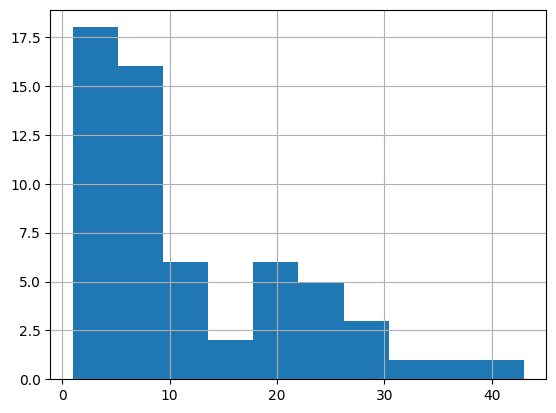

In [13]:
des['num_events'].hist()

In [27]:
# x = tmp.iloc[7]
# event_type = x['events']
def process_end_event(x):
    event_type = x['events'] # '18' scheduled, '19' manual 
    message = x['message']
    date = x['event_time'].floor("D")
    loc = message.find("Until")
    
    h = message[loc + 6:loc + 8]
    m = message[loc + 9:loc + 11]

    end_time = date + pd.Timedelta(int(h), 'H') + pd.Timedelta(int(m), 'T')
    x['end_time'] = end_time
    
    return x
    
df_ts = df_ts.apply(process_end_event, axis=1)
df_ts
# x[38:43]
# x[35:40]

,date,events,message,event_time,lag_event,diff,diff_hour,weekday,user,hour,minute,time,end_time
0,2022-11-25,19,Phone scheduled cueing started. Until 13:00 Cu...,2022-11-25 12:01:13.166000+00:00,2022-11-27 09:00:19.121000+00:00,1 days 20:59:05.955000,44.984722,4,54hFUuEnJA,12,1,12.016667,2022-11-25 13:00:00+00:00
1,2022-11-27,19,Phone scheduled cueing started. Until 10:00 Cu...,2022-11-27 09:00:19.121000+00:00,2022-11-28 17:13:12.183000+00:00,1 days 08:12:53.062000,32.214722,6,54hFUuEnJA,9,0,9.000000,2022-11-27 10:00:00+00:00
2,2022-11-28,19,Phone scheduled cueing started. Until 18:00 Cu...,2022-11-28 17:13:12.183000+00:00,2022-11-29 17:49:31.522000+00:00,1 days 00:36:19.339000,24.605278,0,54hFUuEnJA,17,13,17.216667,2022-11-28 18:00:00+00:00
3,2022-11-29,19,Phone scheduled cueing started. Until 18:00 Cu...,2022-11-29 17:49:31.522000+00:00,2022-11-30 17:35:52.147000+00:00,0 days 23:46:20.625000,23.772222,1,54hFUuEnJA,17,49,17.816667,2022-11-29 18:00:00+00:00
4,2022-11-30,19,Phone scheduled cueing started. Until 18:00 Cu...,2022-11-30 17:35:52.147000+00:00,2022-12-06 17:05:03.768000+00:00,5 days 23:29:11.621000,143.486389,2,54hFUuEnJA,17,35,17.583333,2022-11-30 18:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,2023-03-23,13,Wearable scheduled cueing started Until 20:00 ...,2023-03-23 15:49:04.669000+00:00,2023-03-24 13:09:08.143000+00:00,0 days 21:20:03.474000,21.334167,3,DKbVAN98Ia,15,49,15.816667,2023-03-23 20:00:00+00:00
11,2023-03-24,13,Wearable scheduled cueing started Until 20:00 ...,2023-03-24 13:09:08.143000+00:00,2023-03-25 12:57:53.691000+00:00,0 days 23:48:45.548000,23.812500,4,DKbVAN98Ia,13,9,13.150000,2023-03-24 20:00:00+00:00
12,2023-03-25,13,Wearable scheduled cueing started Until 20:00 ...,2023-03-25 12:57:53.691000+00:00,2023-03-26 10:04:37.760000+01:00,0 days 20:06:44.069000,20.112222,5,DKbVAN98Ia,12,57,12.950000,2023-03-25 20:00:00+00:00
13,2023-03-26,13,Wearable scheduled cueing started Until 20:00 ...,2023-03-26 10:04:37.760000+01:00,NaT,NaT,NaN,6,DKbVAN98Ia,10,4,10.066667,2023-03-26 21:00:00+01:00


In [ ]:
sample = df_ts.query("user == @id")
idx = pd.date_range(start = pd.Timestamp('05:00:00'), end=pd.Timestamp('23:59:00'), freq='5min').strftime('%H:%M:%S')

sample = sample.assign(day_start_time = lambda x: x['event_time'].dt.round("5T").dt.strftime('%H:%M:%S'), \
                       day_end_time = lambda x: x['end_time'].dt.round("5T").dt.strftime('%H:%M:%S'))
dates = list(sample['date'].unique())
date = dates[4]
df = pd.DataFrame({'time': idx}).set_index('time')
df['val'] = 0
display(sample.query("date == @date"))
for i, r in sample.query("date == @date").iterrows():
    start_time = r['day_start_time']
    end_time = r['day_end_time']
    event = int(r['events'])
    df.loc[start_time:end_time] = event
    
px.line(df, x=df.index, y='val')

In [31]:
patients_info = patients_info.set_index("userId")

In [35]:
# import os
ids = patients_info.query("num_events > 10").index.to_list()
f = open(f"plot/00/concat.html", "a")
for id in ids:
    sample = df_ts.query("user == @id")

    sample = sample.assign(day_start_time = lambda x: x['event_time'].dt.round("5T").dt.strftime('%H:%M:%S'), \
                    day_end_time = lambda x: x['end_time'].dt.round("5T").dt.strftime('%H:%M:%S'))\
                    .assign(info = lambda x: x['day_start_time'].str[:5] + ' - ' + x['day_end_time'].str[:5])\
                            .replace({"19": "Scheduled", "18": "Manual"})
    min_date = sample['date'].min()

    sample['days'] = sample['date'].apply(lambda x: pd.to_datetime(x)-pd.to_datetime(min_date)).dt.days
    sample['day_start_time'] = pd.to_datetime(sample['day_start_time'])
    sample['day_end_time'] = pd.to_datetime(sample['day_end_time'])
    sample['day_end_time'] = sample['day_end_time'].apply(lambda x: x+pd.Timedelta(1,"D") if x.hour == 0 else x)

    platform = patients_info.loc[id, 'platform']
    num_events = patients_info.loc[id, 'num_events'] if not None else 0

    fig = px.timeline(sample, x_start= "day_start_time", x_end="day_end_time", y="days", color="events", \
            hover_data={"day_start_time": False, "day_end_time": False, "info": True, "weekday": True}, \
                    color_discrete_map = {"Scheduled": "#636EFA", "Manual": "#EF553B"},
                    title = f"{id}<br><sup>Platform: {platform}, num_events: {num_events}</sup>")

    fig.update_traces(width=1)
    fig.update_xaxes(ticktext= [d.strftime('%H:%M') for d in sample['day_start_time']], tickformat='%H:%M')
    fig.update_layout(yaxis_range=[0-0.5,max(sample['days'])+0.5])

    fig.write_image(f"plot/00/{id}.png")
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
    
f.close()
    

In [ ]:
# patients_info = patients_info.set_index("userId")
id = 'yHK1hn0pTA'
sample = df_ts.query("user == @id")

sample = sample.assign(day_start_time = lambda x: x['event_time'].dt.round("5T").dt.strftime('%H:%M:%S'), \
                    day_end_time = lambda x: x['end_time'].dt.round("5T").dt.strftime('%H:%M:%S'))\
                    .assign(info = lambda x: x['day_start_time'].str[:5] + ' - ' + x['day_end_time'].str[:5])\
                            .replace({"19": "Scheduled", "18": "Manual"})
min_date = sample['date'].min()

sample['days'] = sample['date'].apply(lambda x: pd.to_datetime(x)-pd.to_datetime(min_date)).dt.days
sample['day_start_time'] = pd.to_datetime(sample['day_start_time'])
sample['day_end_time'] = pd.to_datetime(sample['day_end_time'])
sample['day_end_time'] = sample['day_end_time'].apply(lambda x: x+pd.Timedelta(1,"D") if x.hour == 0 else x)

platform = patients_info.loc[id, 'platform']
num_events = patients_info.loc[id, 'num_events'] if not None else 0

fig = px.timeline(sample, x_start= "day_start_time", x_end="day_end_time", y="days", color="events", \
        hover_data={"day_start_time": False, "day_end_time": False, "info": True, "weekday": True}, \
                color_discrete_map = {"Scheduled": "#636EFA", "Manual": "#EF553B"},
                title = f"{id}<br><sup>Platform: {platform}, num_events: {num_events}</sup>")

fig.update_traces(width=1)
fig.update_xaxes(ticktext= [d.strftime('%H:%M') for d in sample['day_start_time']], tickformat='%H:%M')
fig.update_layout(yaxis_range=[0-0.5,max(sample['days'])+0.5])

fig.show()

In [81]:
sample.head()

,date,events,message,event_time,lag_event,diff,diff_hour,weekday,user,hour,minute,time,end_time,day_start_time,day_end_time,info,days
0,2022-10-15,Scheduled,Phone scheduled cueing started. Until 02:00 Cu...,2022-10-15 01:00:00.885000+01:00,2022-10-15 21:55:29.837000+01:00,0 days 20:55:28.952000,20.924444,5,yHK1hn0pTA,1,0,1.000000,2022-10-15 02:00:00+01:00,2023-03-28 01:00:00,2023-03-28 02:00:00,01:00 - 02:00,0
1,2022-10-15,Scheduled,Phone scheduled cueing started. Until 23:00 Cu...,2022-10-15 21:55:29.837000+01:00,2022-10-16 09:35:57.978000+01:00,0 days 11:40:28.141000,11.674444,5,yHK1hn0pTA,21,55,21.916667,2022-10-16 23:00:00+01:00,2023-03-28 21:55:00,2023-03-28 23:00:00,21:55 - 23:00,0
2,2022-10-16,Scheduled,Phone scheduled cueing started. Until 23:00 Cu...,2022-10-16 09:35:57.978000+01:00,2022-10-16 11:30:08.551000+01:00,0 days 01:54:10.573000,1.902778,6,yHK1hn0pTA,9,35,9.583333,2022-10-16 23:00:00+01:00,2023-03-28 09:35:00,2023-03-28 23:00:00,09:35 - 23:00,1
3,2022-10-16,Scheduled,Phone scheduled cueing started. Until 23:00 Cu...,2022-10-16 11:30:08.551000+01:00,2022-10-16 12:58:03.759000+01:00,0 days 01:27:55.208000,1.465278,6,yHK1hn0pTA,11,30,11.500000,2022-10-16 23:00:00+01:00,2023-03-28 11:30:00,2023-03-28 23:00:00,11:30 - 23:00,1
4,2022-10-16,Scheduled,Phone scheduled cueing started. Until 23:00 Cu...,2022-10-16 12:58:03.759000+01:00,2022-10-16 21:17:38.877000+01:00,0 days 08:19:35.118000,8.326389,6,yHK1hn0pTA,12,58,12.966667,2022-10-17 23:00:00+01:00,2023-03-28 13:00:00,2023-03-28 23:00:00,13:00 - 23:00,1


# XGBoost

## preprocess

In [36]:
df = df_ts.groupby(["user", "date"]).count().reset_index().query("user in @ids").filter(["user","date"]).assign(Morning = 0, Afternoon=0, Night=0)
df = df.melt(id_vars=['user', 'date'], value_vars=['Morning', 'Afternoon', 'Night'], var_name = 'day_part', value_name='cueing')

In [37]:
df_ts = df_ts.assign(day_start_time = lambda x: x['event_time'].dt.round("5T").dt.strftime('%H:%M:%S'), \
                    day_end_time = lambda x: x['end_time'].dt.round("5T").dt.strftime('%H:%M:%S'))\
                    .assign(info = lambda x: x['day_start_time'].str[:5] + ' - ' + x['day_end_time'].str[:5]) 

In [38]:
# x = df_ts.iloc[0]['day_start_time']
def day_part(x):
    if x >= "06:00:00" and x <= "12:00:00": return "Morning"
    elif x > "12:00:00" and x <= "18:00:00": return "Afternoon"
    
    return "Night"
    
df_ts['day_part'] = df_ts["day_start_time"].apply(day_part)

In [ ]:
df_ts

In [40]:
# df.merge(df_ts, how="left", on=['user', 'date', 'day_part']).filter(["user", "date", "day_part", "cueing", "info"])
tmp = df_ts.groupby(["user", "date", "day_part"]).first().filter(["events", "info"]).reset_index()
df = df.merge(tmp, how='left', on=['user', 'date', 'day_part'])
df['cueing'] = df['info'].apply(lambda x: 0 if pd.isna(x) else 1)
df

,user,date,day_part,cueing,events,info
0,1r2J9taZha,2022-10-14,Morning,0,NaN,NaN
1,1r2J9taZha,2022-10-15,Morning,1,19,08:55 - 22:00
2,1r2J9taZha,2022-10-16,Morning,1,19,07:00 - 22:00
3,1r2J9taZha,2022-10-17,Morning,1,19,07:10 - 22:00
4,1r2J9taZha,2022-10-18,Morning,1,19,07:10 - 22:00
...,...,...,...,...,...,...
1378,yHK1hn0pTA,2022-10-21,Night,1,19,21:10 - 23:00
1379,yHK1hn0pTA,2022-10-22,Night,1,19,20:20 - 23:00
1380,yHK1hn0pTA,2022-10-23,Night,1,19,22:45 - 23:00
1381,yHK1hn0pTA,2022-10-24,Night,0,NaN,NaN


In [41]:
df= df.merge(df.groupby("user").agg({'date': 'min'}).rename(columns={'date': 'min_date'}).reset_index(), how='left', on='user')\
        .assign(days = lambda x: (pd.to_datetime(x['date']) - pd.to_datetime(x['min_date'])).dt.days)

In [ ]:
df = df.merge(patients_info.filter(['gender', 'ageRange', 'ethnicGroup', 'platform', 'num_events']), how='left', left_on='user', right_index=True)
df.to_parquet("data/trial_freeliving.parquet")

In [ ]:
patients_info['group'] = patients_info['cueingMethod1'].apply(lambda x: 'A' if x == 'cueband' else 'B')
df = df.merge(patients_info.filter(['gender', 'ageRange', 'ethnicGroup', 'platform', 'num_events', 'group']), how='left', left_on='user', right_index=True)

In [46]:
# df.groupby('user').agg({'group': 'count'})
df.to_parquet("data/trial_freeliving.parquet")

## XGboost diaryEntries data

In [ ]:
diaryEntries = pd.read_parquet("data/diaryEntries.parquet")
freeliving_diary = pd.read_parquet("data/freeliving_diary.parquet")

diaryEntries = pd.concat([diaryEntries, freeliving_diary]).reset_index(drop=True)
diaryEntries

In [57]:
diaryEntries = diaryEntries.assign(date = lambda x: x["recordedTime"].dt.strftime("%Y-%m-%d"))
diaryEntries = diaryEntries.sort_values(['user', 'recordedTime'])
diaryEntries['date_lag'] = diaryEntries.groupby(['user'])['date'].shift(-1)


In [67]:
id = 'yHK1hn0pTA'
date = '2022-10-15'
diaryEntries.query("user == @id and date == @date")

,createdAt,updatedAt,localId,month,year,frequency,duration,severity,partialAssessment,user,objectId,recordedTime.__type,recordedTime.iso,dayDate.__type,dayDate.iso,recordedTime,date,date_lag
20,2022-10-28 13:57:45.493000+01:00,2022-10-28 13:57:45.493000+01:00,2,10,2022,13,19,17,None,yHK1hn0pTA,8o2ldrgTl9,Date,2022-10-15 22:31:34.253000+01:00,Date,2022-10-15 00:00:00+00:00,2022-10-15 21:31:34.253000+01:00,2022-10-15,2022-10-16


In [58]:
df= pd.merge(df, diaryEntries.filter(['user', 'date_lag','frequency', 'duration', 'severity']), how = 'left', left_on=['user', 'date'], right_on = ['user', 'date_lag']).fillna(0)#.query("user == @id")

In [59]:
df['events'] = df['events'].astype(int)
df['info'] = df['info'].astype(str)
df['ethnicGroup'] = df['ethnicGroup'].astype(str)
df['date_lag'] = df['date_lag'].astype(str)

In [61]:
# df.to_parquet("data/xgboost_data.parquet")
df.to_parquet("data/freeliving_and_trial_data.parquet")

# Visualising time-series events

In [5]:
def cueingDate(x):
    # Manula cueingInterval
    createdAt = x['createdAt'].round(freq='D')
    createdWD = createdAt.weekday()
    schWD = x['weekDay']
    start_sch = createdAt - pd.Timedelta(createdWD, unit='d') + pd.Timedelta(schWD, unit='d') \
        # + pd.Timedelta(x['startTimeHours'], unit='H') + pd.Timedelta(x['startTimeMinutes'], unit='T')
    if start_sch < createdAt:
        start_sch += pd.Timedelta(7, 'd')
    x['start_sch'] = start_sch
    cueingDate = pd.date_range(start_sch, freq='7D', periods=8).to_list()
    x['cueingDate'] = cueingDate
    
    return x

def create_cueing_events(x):
    # create Manual Cueing Events
    dates = x['cueingDate']
    # createdAt = x['createdAt']
    startTime = pd.Timedelta(x['startTimeHours'], 'H') + pd.Timedelta(x['startTimeMinutes'], 'T')
    endTime = pd.Timedelta(x['endTimeHours'], 'H') + pd.Timedelta(x['endTimeMinutes'], 'T')
    df = pd.DataFrame({'date': dates})
    df["date"] = df['date'].dt.round("d")
    df['source'] = 'createdInterval'
    df['events'] = 'Scheduled'
    df['message'] = f'Scheduled Cueing until {endTime}'
    df['user'] = x['user']
    df['duration'] = x['duration']
    # df['date'] = df['date'].dt.tz_localize(None)
    
    df['startCueingTime'] = df['date'].apply(lambda x: x + startTime).dt.tz_convert("Europe/London")
    df['endCueingTime'] = df['date'].apply(lambda x: x + endTime).dt.tz_convert("Europe/London")
    
    return df

cueingIntervals = cueingIntervals.apply(cueingDate, axis=1)
cueingEvents = pd.concat([create_cueing_events(row) for _, row in cueingIntervals.iterrows()]).reset_index(drop=True)
# cueingEvents['startCueingTime'] = cueingEvents['startCueingTime'].dt.tz_convert("Europe/London")
# cueingEvents['endCueingTime'] = cueingEvents['endCueingTime'].dt.tz_convert("Europe/London")
timechanged = pd.to_datetime('2022-10-30').tz_localize("Europe/London")
cueingEvents['startCueingTime'] = cueingEvents['startCueingTime'].apply(lambda x: x + pd.Timedelta(1, 'H') if x.floor("D") == timechanged else x) # TZ change in phone automaticly
cueingEvents['endCueingTime'] = cueingEvents['endCueingTime'].apply(lambda x: x + pd.Timedelta(1, 'H') if x.floor("D") == timechanged else x)

def diary_message(x):
    frequency = x['frequency']
    duration = x['duration']
    severity = x['severity']
    
    x['message'] = f"{frequency} - {duration} - {severity}"
    
    return x


In [99]:
group = 'B'
id = 'mkxN5gMcg2'
pd.options.display.max_colwidth = None
pd.options.display.width = None
group = 'A' if patients_info.query("userId == @id")['cueingMethod1'].iloc[0] == 'phone' else 'B'
if group == 'A':
    start = pd.to_datetime(patients_info.query("userId == @id")['cueingMethod1Start'].values[0]).tz_localize("Europe/London")
    end = pd.to_datetime(patients_info.query("userId == @id")['cueingMethod1End'].values[0]).tz_localize("Europe/London")
else: 
    start = pd.to_datetime(patients_info.query("userId == @id")['cueingMethod2Start'].values[0]).tz_localize("Europe/London")
    end = pd.to_datetime(patients_info.query("userId == @id")['cueingMethod2End'].values[0]).tz_localize("Europe/London")

df1 = cueingEvents.query(f"user == '{id}'").rename(columns={'startCueingTime': 'event_time'}) \
        .assign(event_time = lambda x: x['event_time'])\
        .filter(['event_time', 'events', 'message', 'source']) \
        .query("event_time >= @start and event_time <= @end")

df2 = block.query(f"user == '{id}'").assign(source = 'blockSample')\
        .assign(event_time = lambda x: x['event_time'].dt.tz_convert("Europe/London"))\
        .filter(['event_time', 'events', 'events_detail', 'source']) \
        .rename(columns={'events_detail': 'message'}) \
        .query("event_time >= @start and event_time <= @end") \
        .query('events > 1024')
        # .query('events ==1024 or events == 2048 or events == 4096 or events == 8192 or events == 16384 or events == 32768') \
        
df3 = appLogs.query(f"user == '{id}'").assign(source = 'appLog')\
        .assign(event_time = lambda x: x['timestamp.iso'].dt.tz_convert("Europe/London"))\
        .filter(['event_time', 'message', 'events', 'source']) \
        .query("event_time >= @start and event_time <= @end") \
        .query('(events >=10 and events <= 19) or (events >=25 and events <=31)') \
        
        # .query('events ==20 or events == 21 or events == 33 or events == 34') \
        # .drop_duplicates(subset=['createdAt', 'events']) \

df4 = diaryEntries.query(f"user == '{id}'").assign(source='diaryEntry') \
        .assign(event_time = lambda x: x['recordedTime'].dt.tz_convert("Europe/London"))\
        .apply(diary_message, axis=1) \
        .assign(events = 'diaryEntries') \
        .filter(['event_time','message', 'events', 'source'])\
        .query("event_time >= @start and event_time <= @end")
                

error_date = pd.Timestamp("2022-01-01").tz_localize("Europe/London") # remove 1970 error

df = pd.concat([df1, df3, df4]).sort_values(by = 'event_time').sort_values(by='event_time').reset_index(drop=True)\
        .assign(events = lambda x: x['events'].astype(str)) \
        .assign(weekday = lambda x: x['event_time'].dt.weekday).drop_duplicates(subset=['event_time', 'events']) \
        # .query('event_time >= @error_date')
ts = df.assign(date= lambda x: x.event_time.dt.strftime('%Y-%m-%d')).groupby(["date", "events", "message"])\
        .agg({"event_time": 'first', "source": 'count', "weekday": 'first'}).rename(columns={"source": "count_col"})\
        .reset_index().assign(hour = lambda x: x.event_time.dt.hour, minute = lambda x: x.event_time.dt.minute).assign(time = lambda x: x.hour + x.minute/60)\
        .sort_values("event_time")
vis = ts
        
keep = ['17', '18', '19', '25', '27', '30']
ts = ts.query("events in @keep")
ts = ts.assign(diff = ts['event_time'].shift(-1) - ts['event_time'], \
                diff_hour= (ts['event_time'].shift(-1) - ts['event_time']).dt.days*24 + (ts['event_time'].shift(-1) - ts['event_time']).dt.seconds/3600, \
                lag_event = ts['event_time'].shift(-1))\
                .filter(["date", "events", "message", "event_time", "lag_event", "diff", "diff_hour", "count_col", "weekday", "hour", "minute", "time"])\
                .query("diff_hour > 11/60 and (events == '18' or events == '19')").assign(user = id).reset_index(drop=True)
                
ts = ts.assign(diff = ts['event_time'].shift(-1) - ts['event_time'], \
                diff_hour= (ts['event_time'].shift(-1) - ts['event_time']).dt.days*24 + (ts['event_time'].shift(-1) - ts['event_time']).dt.seconds/3600, \
                lag_event = ts['event_time'].shift(-1))
df.head(20)

,event_time,events,message,source,weekday
0,2022-12-05 16:02:17.647000+00:00,18,Phone manual cueing started. Until 16:12 Cueing period: 30 seconds. Vibration pattern: 3x Times. Vibration intensity: Default,appLog,0
1,2022-12-05 16:02:27.831000+00:00,25,Manual Cueing stopped on phone,appLog,0
2,2022-12-05 16:03:58.360000+00:00,19,Phone scheduled cueing started. Until 19:00 Cueing period: 30 seconds. Vibration pattern: 3x Times. Vibration intensity: Default,appLog,0
3,2022-12-05 17:00:32.650000+00:00,19,Phone scheduled cueing started. Until 19:00 Cueing period: 30 seconds. Vibration pattern: 3x Times. Vibration intensity: Default,appLog,0
4,2022-12-05 17:01:45.797000+00:00,diaryEntries,70 - 74 - 76,diaryEntry,0
5,2022-12-06 08:00:00+00:00,Scheduled,Scheduled Cueing until 0 days 12:00:00,createdInterval,1
6,2022-12-06 08:17:16.175000+00:00,19,Phone scheduled cueing started. Until 12:00 Cueing period: 30 seconds. Vibration pattern: 3x Times. Vibration intensity: Default,appLog,1
7,2022-12-06 14:00:00+00:00,Scheduled,Scheduled Cueing until 0 days 19:00:00,createdInterval,1
8,2022-12-06 14:18:37.312000+00:00,19,Phone scheduled cueing started. Until 19:00 Cueing period: 30 seconds. Vibration pattern: 3x Times. Vibration intensity: Default,appLog,1
10,2022-12-06 17:01:37.680000+00:00,19,Phone scheduled cueing started. Until 19:00 Cueing period: 30 seconds. Vibration pattern: 3x Times. Vibration intensity: Default,appLog,1


### Visualisation

In [347]:
color_map = {
    'diaryEntry': '#22aad8',
    'blockSample': '#7422d8',
    'appLog': '#d8bd22',
}

display(score_pannel.filter(col).query('userId == @id'))
fig = px.scatter(df, x='event_time', y='events', color='source', hover_data=['message', 'weekday'], color_discrete_map= color_map)
fig.show()

,createdAt,userId,cueingMethod1,cueingMethod2,cueingMethod1Start,cueingMethod1End,cueingMethod2Start,cueingMethod2End,ethnicGroup,phase,nmsq_score,pdq8_score,updrs22_score,romps_score,gender,ageRange
124,2022-10-14 20:48:21.430000+01:00,M6AnBk7QDC,phone,cueband,2022-10-14 20:57:38.346000+01:00,2022-11-04 09:43:21.737000+00:00,2022-11-18 21:20:16.139000+00:00,2022-12-09 16:05:22.242000+00:00,None,0,10,6,3,17,Male,55-64 years
125,2022-11-04 09:57:50.776000+00:00,M6AnBk7QDC,phone,cueband,2022-10-14 20:57:38.346000+01:00,2022-11-04 09:43:21.737000+00:00,2022-11-18 21:20:16.139000+00:00,2022-12-09 16:05:22.242000+00:00,None,1,5,1,3,13,Male,55-64 years
126,2022-11-18 21:19:57.595000+00:00,M6AnBk7QDC,phone,cueband,2022-10-14 20:57:38.346000+01:00,2022-11-04 09:43:21.737000+00:00,2022-11-18 21:20:16.139000+00:00,2022-12-09 16:05:22.242000+00:00,None,2,7,1,3,13,Male,55-64 years
127,2022-12-09 16:16:18.725000+00:00,M6AnBk7QDC,phone,cueband,2022-10-14 20:57:38.346000+01:00,2022-11-04 09:43:21.737000+00:00,2022-11-18 21:20:16.139000+00:00,2022-12-09 16:05:22.242000+00:00,None,3,6,2,2,14,Male,55-64 years


In [252]:
# pd.options.display.max_colwidth = None
# pd.options.display.width = None

## Group by events, predict period of cueing effect

In [ ]:
df

In [ ]:
vis

In [ ]:
px.line(ts, x='date', y='time', hover_data=["events", "message"], color="events")

In [ ]:
keep = ['17', '18', '19', '25', '27', '30']
ts = ts.query("events in @keep")
ts.assign(diff = ts['event_time'].shift(-1) - ts['event_time'], \
        diff_hour= (ts['event_time'].shift(-1) - ts['event_time']).dt.days*24 + (ts['event_time'].shift(-1) - ts['event_time']).dt.seconds/3600, \
        lag_event = ts['event_time'].shift(-1))\
        .filter(["date", "events", "message", "event_time", "lag_event", "diff", "diff_hour", "count_col", "weekday", "hour", "minute", "time"])\
        .query("diff_hour > 11/60 and (events == '18' or events == '19') ")

# tmp['diff'].dt.seconds//3600 
# tmp.to_parquet(f"data/predict_period_{id}.parquet")

In [336]:
ts.query("date == '2022-10-31'")

,date,events,message,event_time,count_col,weekday,hour,minute,time
4,2022-10-31,Scheduled,Scheduled Cueing until 0 days 10:00:00,2022-10-31 09:00:00+00:00,1,0,9,0,9.0


In [197]:
cueingIntervals.query("user == @id").filter(["createdAt", "startTimeHours", "startTimeMinutes", "endTimeHours", "endTimeMinutes", "weekDay"])

,createdAt,startTimeHours,startTimeMinutes,endTimeHours,endTimeMinutes,weekDay
0,2022-10-27 14:54:36.068000+01:00,7,0,22,0,0
1,2022-10-27 14:54:36.169000+01:00,7,0,22,0,1
2,2022-10-27 14:54:36.278000+01:00,7,0,22,0,2
3,2022-10-27 14:54:36.361000+01:00,7,0,22,0,3
4,2022-10-27 14:54:36.462000+01:00,7,0,22,0,4
5,2022-10-27 14:54:36.553000+01:00,7,0,22,0,5
6,2022-10-27 14:54:36.647000+01:00,7,0,22,0,6


In [ ]:
start = pd.Timestamp("2022-10-14").tz_localize("Europe/London")
end = pd.Timestamp("2022-10-15").tz_localize("Europe/London")
color_map = {
    'diaryEntry': '#22aad8',
    'blockSample': '#7422d8',
    'appLog': '#d8bd22',
}
vis = df.query(f"event_time >='{start}' and event_time <= '{end}'")
# pd.options.display.max_colwidth = None
# pd.options.display.width = None
pd.reset_option('^display.', silent=True)
display(vis.head())
display(score_pannel.filter(col).query('userId == @id'))
fig = px.scatter(df, x='event_time', y='events', color='source', hover_data=['message', 'weekday'], color_discrete_map= color_map)
fig.show()

In [ ]:
df

In [41]:
df['date'] = df['event_time'].dt.date 
tmp = df.groupby('date').agg('count')

In [ ]:
px.line(tmp['events'])

In [71]:
df4.query(f"event_time >=@start and event_time <= @end")

,event_time,message,events,source
10,2022-10-13 21:03:58.508000+01:00,57 - 15 - 30,diaryEntries,diaryEntry


In [49]:
df4 = diaryEntries.query(f"user == '{id}'").assign(source='diaryEntry') \
        .assign(event_time = lambda x: x['recordedTime.iso'].dt.tz_convert("Europe/London"))
df4.query("partialAssessment == True")

,createdAt,updatedAt,localId,month,year,frequency,duration,severity,partialAssessment,user,objectId,recordedTime.__type,recordedTime.iso,dayDate.__type,dayDate.iso,recordedTime,source,event_time
0,2022-09-30 17:34:03.002000+01:00,2022-09-30 17:34:03.002000+01:00,1,9,2022,52,49,74,True,qIbpO14xtQ,Z1CDEmbTw8,Date,2022-09-30 18:34:02.956000+01:00,Date,2022-09-30 00:00:00+00:00,2022-09-30 17:34:02.956000+01:00,diaryEntry,2022-09-30 18:34:02.956000+01:00


In [90]:
diaryEntries[(diaryEntries['recordedTime.iso'] >= start) & (diaryEntries['recordedTime.iso'] <= end)].query(f"user == @id")

,createdAt,updatedAt,localId,month,year,frequency,duration,severity,partialAssessment,user,objectId,recordedTime.__type,recordedTime.iso,dayDate.__type,dayDate.iso
10,2022-10-13 19:03:57.502000+00:00,2022-10-13 19:03:57.502000+00:00,11,10,2022,57,15,30,False,JqZPr3q1LD,oUFGkAoRB2,Date,2022-10-13 20:03:58.508000+00:00,Date,2022-10-13 00:00:00+00:00


In [ ]:
diaryEntries.query(f"user == @id")

In [ ]:
cueingIntervals.query(f"user =='{id}'")

In [ ]:
df3 = appLogs.query(f"user == '{id}'").assign(source = 'appLog')\
        .assign(event_time = lambda x: x['timestamp.iso'].dt.tz_convert("Europe/London"))
df3

In [39]:
df = blockSamples.query(f"user == '{id}'")

In [42]:
df['events'].nunique()

103

In [ ]:
scheduled_events = [16, 19, 20, 21, 27, 32, 33, 34]
appLog = appLogs[appLogs['events'].isin(scheduled_events)]
appLog = appLog.query(f"user == '{id}'")
appLog


In [ ]:
fig1 = px.scatter(appLogs.query(f"user == '{id}'"), x='createdAt', y='events', hover_data=['message'])
fig2 = px.scatter(appLog, x='createdAt', y='events', hover_data=['message'])
fig2.show()

In [7]:
assessmentA.to_csv('data/assessmentA.csv', index=False)
assessmentQ_likert.to_csv('data/assessmentQ_likert.csv', index=False)
assessmentQ_radio.to_csv('data/assessmentQ_radio.csv', index=False)

# Free living

In [4]:
file1 = 'data/freeLivingParticipants.json'
# london_tz = 'Europe/London'

with open(file1, 'rb') as f:
    data = json.load(f)

userIds = list(data.keys())
id = 'QOQ0hkp1w8'
print(data.keys(), len(data.keys()))

dict_keys(['Ha1WEar7EW', 'HvxJHYzJJq', '431V37PJr1', 'UXiE2yKo6S', 'wWtIentHji', 'ZpApCmwwcR', 'oyVbiGrfZP', 'xUAgz8E45S', 'TGzpi2zPjC', 'KqoDQeYYhk', 'PS0pBhRMti', 'Cn3qav4Fku', 'yCvheaYXrD', '44bFt8AYNc', 'W6Cg0j7N00', 'BjTkuez4di', 'XmoVGAQABx', 'yyj7riMAjT', '8dvzDHwJ7Z', 'bHfaLYaLOz', 'CRqMAJH5v1', 'gHV6jfyIAK', 'PPTdoXttbn', 'BY9JrqFVpg', 'eMy20NZL8D', 'MLsm9Xy9N2', 'ycAloEmo3J', '1UXpAssVmB', 'T90VjPCkfa', 'p7ef4nI48m', 'ZhYNKlzwn8', 'hIDRROby2j', '4gkPRFEplK', '94LwBmw2Ec', 'yBUvAWEt49', 'mtY7dACp1y', '72pLbMGYfV', 'nr7NIGJTbu', 'CqXUVcyUWC', 'kSzqsPVv10', 's8wtIjITxx', 'uzfF0FE2Ep', 'xmfKE4nK6u', 'heGCpWirRL', 'rGHrkeCNBf', 'o3YBXOYdMK', 'fyqEP00qbX', 'Ys0M5lUaZF', 'iqREz2wbus', '3kmqoheMHw', 'UNorJGZt4p', 'I1Hx67LeQB', 'xvPUnmfVCu', 'yvybX2kbIe', 'KcvPHeDRHo', 'kMNnYGz6yL', 'm3hpwcYulH', 'SdXaRAR4Ow', 'GRKG1mJkNo', 'nYaQS9Ulkq', 'UCkgGOkRts', 'EhKR6BAnHA', 'XJjx4T4rkE', 'HY3FKNJUiy', 'PjScElirG3', 'oFteR0cASq', 'zdiALOlh2I', 'L8gnBFppsj', 'D5bvf5Wjfp', 'UPxYC0gdNk', 'Pc4lU4rE

In [ ]:
from tqdm import tqdm
userIds = data.keys()

diaryEntries = []
cueingIntervals = []
appLogs = []
blockSamples = []
blockHeaders = []

def process_patient(id):
    sample = data[id]
    
    diaryEntry = pd.json_normalize(sample['diaryEntry'])
    diaryEntry['createdAt'] = pd.to_datetime(diaryEntry['createdAt']).dt.tz_convert('Europe/London')
    diaryEntry['updatedAt'] = pd.to_datetime(diaryEntry['updatedAt']).dt.tz_convert('Europe/London')
    diaryEntry['recordedTime.iso'] = pd.to_datetime(diaryEntry['recordedTime.iso']).dt.tz_convert('Europe/London')
    diaryEntry['dayDate.iso'] = pd.to_datetime(diaryEntry['dayDate.iso'])
    diaryEntry = diaryEntry.sort_values(by='createdAt')
    
    cueingInterval = pd.json_normalize(sample['cueingInterval'])
    if cueingInterval.shape[0] > 0:
        cueingInterval['createdAt'] = pd.to_datetime(cueingInterval['createdAt']).dt.tz_convert('Europe/London')
        cueingInterval['updatedAt'] = pd.to_datetime(cueingInterval['updatedAt']).dt.tz_convert('Europe/London')
        cueingInterval = cueingInterval.sort_values(by='createdAt')
    else:
        print('No CueingInterval' + id)
        
    appLog = pd.json_normalize(sample['appLogs'])
    if appLog.shape[0] > 0:
        appLog['createdAt'] = pd.to_datetime(appLog['createdAt']).dt.tz_convert('Europe/London')
        appLog['updatedAt'] = pd.to_datetime(appLog['updatedAt']).dt.tz_convert('Europe/London')
        appLog['timestamp.iso'] = pd.to_datetime(appLog['timestamp.iso'])
        appLog = appLog.sort_values(by='createdAt')
    else:
        print('No AppLog' + id)

    return diaryEntry, cueingInterval, appLog


for i in tqdm(userIds):
    diaryEntry, cueingInterval, appLog = process_patient(i)
    
    diaryEntries.append(diaryEntry)
    cueingIntervals.append(cueingInterval)
    appLogs.append(appLog)
    # blockHeaders.append(blockHeader)
    
diaryEntries = pd.concat(diaryEntries)
cueingIntervals = pd.concat(cueingIntervals)
appLogs = pd.concat(appLogs)
# blockHeaders = pd.concat(blockHeaders)

display(diaryEntries.shape)
display(cueingIntervals.shape)
display(appLogs.shape)
# display(blockHeaders.shape)

In [53]:
diaryEntries.to_parquet("data/freeliving_diary.parquet")

In [6]:
def message_encode(x):
    if "Application started" in x: return 0
    elif "Saving delivery address" in x: return 1
    elif "Connecting To New Device: " in x: return 2
    elif "Connecting To Already Bonded Device: " in x: return 3
    elif "Bonding Device" in x: return 4
    elif "Bonding Device Cancelled" in x: return 5
    elif "Scan Device Cancelled" in x: return 6
    elif "Scanning - No devices found" in x: return 7
    elif "Start scanning" in x: return 8
    elif "Added new diary entry" in x: return 9
    elif "Manually changed cueing type to" in x: return 10
    
    elif "Wearable muted cueing started" in x: return 11
    elif "Wearable manual cueing started " in x: return 12
    elif "Wearable scheduled cueing started " in x: return 13
    elif "Wearable manual cueing started " in x: return 14
    elif "Wearable muted cueing started " in x: return 15
    elif "Wearable scheduled cueing started " in x: return 16
    
    elif "Phone muted cueing started. " in x: return 17
    elif "Phone manual cueing started. " in x: return 18
    elif "Phone scheduled cueing started. " in x: return 19
    
    elif "Cueing interval updated to " in x: return 20
    elif "Cueing Interval Deleted - StartTime: " in x: return 21
    
    elif "Vibration intensity updated to " in x: return 22
    elif "Vibration pattern updated to " in x and "on phone" in x: return 23
    elif "Vibration pattern updated to " in x and "on wearable": return 24
    
    elif "Manual Cueing stopped on phone" in x: return 25
    elif "Manual Cueing stopped on wearable" in x: return 26
    
    elif "Scheduled cueing muted completely" in x: return 27
    elif "Silence mode stopped on phone" in x: return 28
    elif "Silence mode stopped on CueBand" in x: return 29
    
    elif "Muted scheduled cueing on phone for " in x: return 30
    elif "Muted scheduled cueing on wearable for" in x: return 31
    
    elif "Change Cueing Settings: CueingInterval: " in x: return 32
    elif "New Cueing Interval Created - StartTime: " in x: return 33
    elif "Updated Cueing Interval Created - StartTime: " in x: return 34

    return 35

appLogs['events'] = appLogs['message'].apply(message_encode)

In [10]:
print(diaryEntries['user'].nunique())
print(cueingIntervals['user'].nunique())
print(appLogs['user'].nunique())

96
47
95


In [11]:
appLogs.groupby(['user', 'events']).count()

createdAt  updatedAt  message  level  appVersion  \
user       events                                                     
1UXpAssVmB 0               1          1        1      1           1   
           35             25         25       25     25          25   
39DE9fE5uv 0              26         26       26     26          26   
           1               2          2        2      2           2   
           8               1          1        1      1           1   
...                      ...        ...      ...    ...         ...   
zdiALOlh2I 11              2          2        2      2           2   
           12              7          7        7      7           7   
           18              1          1        1      1           1   
           32              2          2        2      2           2   
           33              1          1        1      1           1   

                   deviceModel  osVersion  platform  objectId  \
user       events                                               
1UXpAssVmB 0                 1          1         1         1   
           35               25         25        25        25   
39DE9fE5uv 0                26         26        26        26   
           1                 2          2         2         2   
           8                 1          1         1         1   
...                        ...        ...       ...       ...   
zdiALOlh2I 11                2          2         2         2   
           12                7          7         7         7   
           18                1          1         1         1   
           32                2          2         2         2   
           33                1          1         1         1   

                   timestamp.__type  timestamp.iso  
user       events                                   
1UXpAssVmB 0                      1              1  
           35                    25             25  
39DE9fE5uv 0                     26             26  
           1                      2              2  
           8                      1              1  
...                             ...            ...  
zdiALOlh2I 11                     2              2  
           12                     7              7  
           18                     1              1  
           32                     2              2  
           33                     1              1  

[907 rows x 11 columns]

In [29]:
appLogs.filter(['user', 'platform']).groupby(['user']).first().reset_index()

,user,platform
0,1UXpAssVmB,iOS
1,39DE9fE5uv,iOS
2,3kmqoheMHw,iOS
3,431V37PJr1,Android
4,44bFt8AYNc,iOS
...,...,...
90,yCvheaYXrD,Android
91,ycAloEmo3J,Android
92,yvybX2kbIe,iOS
93,yyj7riMAjT,iOS


In [34]:
data2 = json.load(open('data/freeLivingParticipants.json', 'rb'))
extract = [(data2[keys]['demographicData'], keys) for keys in data2.keys()]
info2 = []
for x, id in extract:
    x.update({"userId": id})
    info2.append(x)
    
info_free_living = pd.json_normalize(info2)
info_free_living = info_free_living.merge(appLogs.filter(['user', 'platform']).groupby(['user']).first().reset_index(), how='left', left_on='userId', right_on='user')
info_free_living.to_parquet('data/freeliving_info.parquet')

In [12]:
# id = 'hWKgqVxmMM'
def appLog_preprocess(id):
            
    df3 = appLogs.query(f"user == '{id}'").assign(source = 'appLog')\
            .assign(event_time = lambda x: x['timestamp.iso'].dt.tz_convert("Europe/London"))\
            .filter(['event_time', 'message', 'events', 'source']) \
            .query('(events >=10 and events <= 19) or (events >=25 and events <=31)') \
            
            # .query('events ==20 or events == 21 or events == 33 or events == 34') \
            # .drop_duplicates(subset=['createdAt', 'events']) \              

    error_date = pd.Timestamp("2022-01-01").tz_localize("Europe/London") # remove 1970 error

    df = pd.concat([df3]).sort_values(by = 'event_time').sort_values(by='event_time').reset_index(drop=True)\
            .assign(events = lambda x: x['events'].astype(str)) \
            .assign(weekday = lambda x: x['event_time'].dt.weekday).drop_duplicates(subset=['event_time', 'events']) \
            .query('event_time >= @error_date')
    ts = df.assign(date= lambda x: x.event_time.dt.strftime('%Y-%m-%d'))\
            .reset_index().assign(hour = lambda x: x.event_time.dt.hour, minute = lambda x: x.event_time.dt.minute)\
            .assign(time = lambda x: x.hour + x.minute/60).assign(user = id)\
            .sort_values("event_time")
    # ts = df.assign(date= lambda x: x.event_time.dt.strftime('%Y-%m-%d')).groupby(["date", "events", "message"])\
    #         .agg({"event_time": 'first', "source": 'count', "weekday": 'first'}).rename(columns={"source": "count_col"})\
    #         .reset_index().assign(hour = lambda x: x.event_time.dt.hour, minute = lambda x: x.event_time.dt.minute)\
    #         .assign(time = lambda x: x.hour + x.minute/60).assign(user = id)\
    #         .sort_values("event_time")

    vis = ts
            
    keep = ['11', '12', '13', '14', '15', '16', '26','31']
    ts = ts.query("events in @keep")
#     print(ts.shape)
    ts = ts.assign(diff = ts['event_time'].shift(-1) - ts['event_time'], \
                    diff_hour= (ts['event_time'].shift(-1) - ts['event_time']).dt.days*24 + (ts['event_time'].shift(-1) - ts['event_time']).dt.seconds/3600, \
                    lag_event = ts['event_time'].shift(-1))\
                    .filter(["date", "events", "message", "event_time", "lag_event", "diff", "diff_hour", "count_col", "weekday", "user", "hour", "minute", "time"])\
                    .query("diff_hour > 11/60 and (events == '12' or events == '13')").reset_index(drop=True)
    ts = ts.assign(diff = ts['event_time'].shift(-1) - ts['event_time'], \
                    diff_hour= (ts['event_time'].shift(-1) - ts['event_time']).dt.days*24 + (ts['event_time'].shift(-1) - ts['event_time']).dt.seconds/3600, \
                    lag_event = ts['event_time'].shift(-1))

    return vis, ts

df_vis = []
df_ts = []

for i in tqdm(userIds):
    vis, ts = appLog_preprocess(i)
    df_vis.append(vis)
    df_ts.append(ts)
    
df_vis = pd.concat(df_vis)
df_ts = pd.concat(df_ts)

df_vis.shape, df_ts.shape

100%|██████████| 96/96 [00:01<00:00, 49.91it/s]


((7030, 11), (299, 12))

In [17]:
df_ts.to_parquet("data/df_ts_free_living.parquet")

In [16]:
df_ts.groupby(['user']).agg({'events': 'count'})#.reset_index()#.query("date > 10")

,events
user,
3kmqoheMHw,3
431V37PJr1,21
CqXUVcyUWC,3
DKbVAN98Ia,14
GRKG1mJkNo,68
HvxJHYzJJq,2
L8gnBFppsj,4
MLsm9Xy9N2,6
NEo7lrEXqm,12


In [19]:
id = 'oFteR0cASq'
tmp = df_vis.query("user == @id")
# display(tmp)
# display(cueingIntervals.query("user == @id").head())
px.line(tmp, x="date", y="time", hover_data=["message"], color="events", markers= True)

In [18]:
tmp = df_ts.query("user == @id")
px.line(tmp, x="date", y="time", hover_data=["message"], color="events", markers= True)

In [29]:
tmp

,date,events,message,event_time,lag_event,diff,diff_hour,weekday,user,hour,minute,time
0,2022-11-14,13,Wearable scheduled cueing started Until 14:55 ...,2022-11-14 14:01:24.631000+00:00,2022-11-14 17:20:25.437000+00:00,0 days 03:19:00.806000,3.316667,0,GRKG1mJkNo,14,1,14.016667
1,2022-11-14,13,Wearable scheduled cueing started Until 18:00 ...,2022-11-14 17:20:25.437000+00:00,2022-11-14 17:33:39.420000+00:00,0 days 00:13:13.983000,0.220278,0,GRKG1mJkNo,17,20,17.333333
2,2022-11-14,13,Wearable scheduled cueing started Until 18:00 ...,2022-11-14 17:33:39.420000+00:00,2022-11-15 17:09:27.990000+00:00,0 days 23:35:48.570000,23.596667,0,GRKG1mJkNo,17,33,17.550000
3,2022-11-15,13,Wearable scheduled cueing started Until 18:00 ...,2022-11-15 17:09:27.990000+00:00,2022-11-16 18:44:36.913000+00:00,1 days 01:35:08.923000,25.585556,1,GRKG1mJkNo,17,9,17.150000
4,2022-11-16,12,Wearable manual cueing started Until 18:54 Cu...,2022-11-16 18:44:36.913000+00:00,2022-11-17 17:00:50.803000+00:00,0 days 22:16:13.890000,22.270278,2,GRKG1mJkNo,18,44,18.733333
...,...,...,...,...,...,...,...,...,...,...,...,...
63,2023-03-13,13,Wearable scheduled cueing started Until 17:59 ...,2023-03-13 17:09:59.988000+00:00,2023-03-15 17:04:19.296000+00:00,1 days 23:54:19.308000,47.905278,0,GRKG1mJkNo,17,9,17.150000
64,2023-03-15,13,Wearable scheduled cueing started Until 17:59 ...,2023-03-15 17:04:19.296000+00:00,2023-03-20 17:36:53.725000+00:00,5 days 00:32:34.429000,120.542778,2,GRKG1mJkNo,17,4,17.066667
65,2023-03-20,13,Wearable scheduled cueing started Until 17:59 ...,2023-03-20 17:36:53.725000+00:00,2023-03-21 17:03:05.436000+00:00,0 days 23:26:11.711000,23.436389,0,GRKG1mJkNo,17,36,17.600000
66,2023-03-21,13,Wearable scheduled cueing started Until 17:59 ...,2023-03-21 17:03:05.436000+00:00,2023-03-22 17:07:00.028000+00:00,1 days 00:03:54.592000,24.065000,1,GRKG1mJkNo,17,3,17.050000
